In [ ]:
import time
import json
import torch
import requests
from tqdm                       import tqdm
from torch                      import nn
from torch.nn                   import functional as F
from matplotlib                 import pyplot as plt
from transformers               import DataCollatorForLanguageModeling, AutoTokenizer, AutoModel
from sklearn.metrics            import accuracy_score, mean_absolute_error
from torch.utils.data           import DataLoader, Dataset
from einops.layers.torch        import Rearrange

from treat                      import TreaT
from tiny_teacher_model         import TinyTransformerTeacher

# Functions and Classes

## Experimental Setup

In [2]:
def download_wikitext2():
    url = "https://raw.githubusercontent.com/pytorch/examples/master/word_language_model/data/wikitext-2/train.txt"
    text = requests.get(url).text
    return [line.strip() for line in text.split('\n') if line.strip()]

class WikiTextDataset(Dataset):
    def __init__(self, lines, tokenizer, block_size=64):
        self.examples = []
        self.tokenizer = tokenizer
        length = len(lines)
        pourcentage = 0.3

        for line in lines[:int(length * pourcentage)]:
            tokens = tokenizer.encode(line, add_special_tokens=True)
            for i in range(0, len(tokens), block_size):
                block = tokens[i:i+block_size]
                if len(block) == block_size:
                    self.examples.append(torch.tensor(block))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]


In [3]:
def compute_metrics(predicted_indices, true_indices):
    y_pred = predicted_indices.view(-1).cpu().numpy()
    y_true = true_indices.view(-1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    return acc, mae

## Linear Attention (for ablation study)

In [49]:
class LinearAttention(nn.Module):

    def __init__(
        self,
        d_model : int
    ):
        super().__init__()

        self.d_model = d_model

        self.kv = nn.Linear(self.d_model, self.d_model * 2, bias = False)
        self.token_emb = teacher.token_emb

        self.q = nn.Linear(self.d_model, self.d_model, bias = False)

        self.rearrange = Rearrange('b l (k d) -> k b l d', k = 2)
        self.split = Rearrange('b (k l) d c -> k b l d c', k = 2)


    def build_summaries(
        self,
        x : torch.Tensor
    ):
        """
        x: (B, L)
        output: (B, )
        """
        B, L = x.shape

        assert (L % 2 == 0), "Need to be divisable in two summaries"

        x_emb = self.token_emb(x)
        k, v = self.rearrange(self.kv(x_emb)) # B, L, D

        kv = k.unsqueeze(-1) @ v.unsqueeze(-2)

        print(kv.shape)
        return self.split(kv).sum(dim=2)


    def forward(
        self,
        q : torch.Tensor,
        summaries : torch.Tensor
    ):
        B, Lk = q.shape

        q_emb = self.token_emb(q)
        proj_q = self.q(q_emb) # B, Lk, D

        left_score = ((proj_q @ summaries[0]).unsqueeze(2) @ proj_q.unsqueeze(-1)).reshape(B, Lk, 1) # B, Lk, D @ B, D, D -> B, Lk, 1, D @ B, L_k, D, 1 -> B, Lk
        right_score = ((proj_q @ summaries[1]).unsqueeze(2) @ proj_q.unsqueeze(-1)).reshape(B, Lk, 1) # B, Lk
        return torch.concat([left_score, right_score], dim=-1)

# Setup and Data Loading

In [ ]:
# ---- Step 1: Setup ----

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ---- Step 2: Load and tokenize WikiText-2 and chunk into blocks ----

lines = download_wikitext2()
lm_dataset = WikiTextDataset(lines, tokenizer, block_size=128)

# ---- Step 3: DataLoader with MLM Collator ----

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
dataloader = DataLoader(lm_dataset, batch_size=8, shuffle=True, collate_fn=collator)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors


# Teacher Training

In [ ]:
teacher = TinyTransformerTeacher(d_model=384, model_name=model_name).to(device)
optimizer = torch.optim.Adam(teacher.parameters(), lr=1e-4)

for epoch in range(50):

    epoch_acc = 0
    for step, batch in enumerate(tqdm(dataloader)):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        logits, attn_weights = teacher(input_ids)

        mask = labels != -100
        preds = logits.argmax(dim=-1)
        correct = (preds == labels) & mask
        accuracy = correct.sum().item() / mask.sum().item()

        epoch_acc += accuracy

        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-100)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Accuracy: {epoch_acc / len(dataloader):.4f}")


# torch.save(teacher.state_dict(), "teacher.pt")

 18%|█▊        | 72/393 [02:52<12:51,  2.40s/it]


KeyboardInterrupt: 

# TreaT Training

In [8]:
teacher.eval()

# === Initialize TreaT ===
hla = TreaT(d_model=teacher.d_model).cuda()
hla.train()

optimizer = torch.optim.Adam(hla.parameters(), lr=1e-4)

# === Training loop ===
loss_results = []
acc_results = []
var_results = []

for epoch in range(3):
    for step, batch in enumerate(tqdm(dataloader)):
        context_ids = batch["input_ids"].cuda()
        labels = batch["labels"].cuda()

        with torch.no_grad():
            logits, attn_weights = teacher(context_ids)  # (B, L, L)
            mask = labels != -100
            preds = logits.argmax(dim=-1)
            correct = (preds == labels) & mask
            top1_indices = attn_weights.argmax(dim=-1)  # (B, L)
        memory_tree = hla.build_tree(context_ids)
        loss = hla.forward(
            query=context_ids,
            memory_tree=memory_tree,
            expected=top1_indices
        )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # --- Evaluate top-1 match ---
        with torch.no_grad():
            B, L = context_ids.shape
            context_embeddings = teacher.token_emb(context_ids)
            predictions = memory_tree.oracle(hla.W_q(context_embeddings))
            acc, var_loss = compute_metrics(predictions, top1_indices)

        print(f"[Epoch {epoch} Step {step}] Loss: {loss.item():.4f} | Acc: {acc:.4f} | Var: {var_loss:.4f}")

        acc_results.append(acc)
        loss_results.append(loss.item())
        var_results.append(var_loss)

        if (step + 1) % 10 == 0:
          fig, ax = plt.subplots(1, 3)

          ax[0].plot(loss_results, color="orange")
          ax[0].legend("Loss Curve")
          ax[1].plot(acc_results, color="green")
          ax[1].legend("Accuracy Curve")
          ax[2].plot(var_results)
          ax[2].legend("Var Curve")
          plt.show()
          time.sleep(0.01)

        open("treat_training_metrics.json", "w").write(json.dumps({
            "loss_curve" : loss_results,
            "acc_curve" : acc_results,
            "var_curve" : var_results
        }))


NameError: name 'teacher' is not defined

# Ablation Study - Linear Attention Choice Accuracy

  1%|          | 3/393 [00:00<00:15, 25.49it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 0] Loss: 16.3150 | Acc: 0.5000
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 1] Loss: 13.4992 | Acc: 0.5586
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 2] Loss: 13.1912 | Acc: 0.6553
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 3] Loss: 10.7246 | Acc: 0.7041
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 4] Loss: 8.9072 | Acc: 0.7461
torch.Size([8, 128, 384, 384])


  3%|▎         | 10/393 [00:00<00:12, 29.60it/s]

[Epoch 0 Step 5] Loss: 9.3941 | Acc: 0.7773
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 6] Loss: 10.6180 | Acc: 0.7822
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 7] Loss: 7.8691 | Acc: 0.8037
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 8] Loss: 7.0857 | Acc: 0.8467
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 9] Loss: 9.0164 | Acc: 0.8525
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 10] Loss: 9.3305 | Acc: 0.8496
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 11] Loss: 6.3067 | Acc: 0.8770
torch.Size([8, 128, 384, 384])


  5%|▍         | 18/393 [00:00<00:10, 34.13it/s]

[Epoch 0 Step 12] Loss: 8.1352 | Acc: 0.8545
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 13] Loss: 16.6111 | Acc: 0.8486
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 14] Loss: 8.4948 | Acc: 0.8408
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 15] Loss: 7.5220 | Acc: 0.8477
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 16] Loss: 5.7130 | Acc: 0.8779
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 17] Loss: 4.7652 | Acc: 0.8789
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 18] Loss: 9.0207 | Acc: 0.8750
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 19] Loss: 8.2459 | Acc: 0.8672
torch.Size([8, 128, 384, 384])


  6%|▌         | 22/393 [00:00<00:10, 35.25it/s]

[Epoch 0 Step 20] Loss: 5.0551 | Acc: 0.8809
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 21] Loss: 6.0258 | Acc: 0.8730
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 22] Loss: 5.4813 | Acc: 0.8779
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 23] Loss: 4.6157 | Acc: 0.8818
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 24] Loss: 5.9368 | Acc: 0.8809


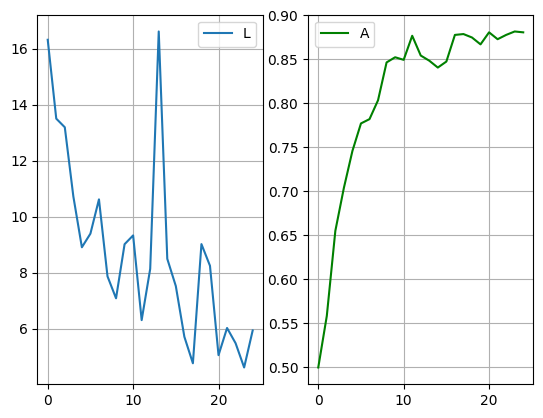

  8%|▊         | 30/393 [00:01<00:15, 23.38it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 25] Loss: 5.2340 | Acc: 0.8906
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 26] Loss: 4.5551 | Acc: 0.8848
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 27] Loss: 4.5824 | Acc: 0.8896
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 28] Loss: 3.8369 | Acc: 0.9014
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 29] Loss: 4.0852 | Acc: 0.8994
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 30] Loss: 3.7450 | Acc: 0.8994
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 31] Loss: 3.5227 | Acc: 0.8916
torch.Size([8, 128, 384, 384])


 10%|▉         | 38/393 [00:01<00:12, 29.15it/s]

[Epoch 0 Step 32] Loss: 4.0583 | Acc: 0.8809
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 33] Loss: 3.4845 | Acc: 0.8867
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 34] Loss: 4.9352 | Acc: 0.8721
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 35] Loss: 3.3792 | Acc: 0.9053
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 36] Loss: 3.4643 | Acc: 0.8896
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 37] Loss: 4.9382 | Acc: 0.8809
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 38] Loss: 2.4640 | Acc: 0.9141
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 39] Loss: 3.5049 | Acc: 0.9238
torch.Size([8, 128, 384, 384])


 12%|█▏        | 46/393 [00:01<00:10, 32.90it/s]

[Epoch 0 Step 40] Loss: 4.9757 | Acc: 0.8857
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 41] Loss: 4.4883 | Acc: 0.9111
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 42] Loss: 4.9207 | Acc: 0.9053
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 43] Loss: 3.9107 | Acc: 0.9072
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 44] Loss: 5.9266 | Acc: 0.8643
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 45] Loss: 3.1635 | Acc: 0.8887
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 46] Loss: 3.3428 | Acc: 0.9053
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 47] Loss: 3.8744 | Acc: 0.9150
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 48] Loss: 3.6762 | Acc: 0.8896
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 49] Loss: 4.7397 | Acc: 0.8926


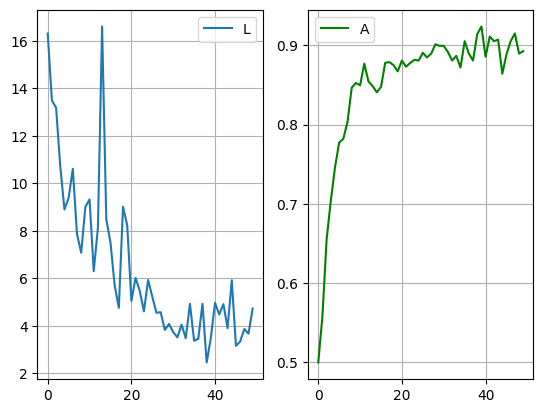

 14%|█▎        | 54/393 [00:02<00:14, 23.80it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 50] Loss: 7.5392 | Acc: 0.8750
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 51] Loss: 2.9694 | Acc: 0.9053
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 52] Loss: 4.5937 | Acc: 0.8916
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 53] Loss: 3.6575 | Acc: 0.8965
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 54] Loss: 3.3826 | Acc: 0.9150
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 55] Loss: 2.8827 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 56] Loss: 5.5061 | Acc: 0.9277
torch.Size([8, 128, 384, 384])


 16%|█▌        | 62/393 [00:02<00:11, 29.20it/s]

[Epoch 0 Step 57] Loss: 7.0549 | Acc: 0.8984
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 58] Loss: 4.4998 | Acc: 0.9219
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 59] Loss: 10.9836 | Acc: 0.9150
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 60] Loss: 2.9865 | Acc: 0.9170
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 61] Loss: 3.4651 | Acc: 0.9053
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 62] Loss: 2.2975 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 63] Loss: 4.5284 | Acc: 0.8887
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 64] Loss: 2.4195 | Acc: 0.9248
torch.Size([8, 128, 384, 384])


 18%|█▊        | 70/393 [00:02<00:09, 32.73it/s]

[Epoch 0 Step 65] Loss: 2.9459 | Acc: 0.9141
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 66] Loss: 4.7236 | Acc: 0.8994
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 67] Loss: 3.4358 | Acc: 0.9092
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 68] Loss: 3.0148 | Acc: 0.9170
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 69] Loss: 2.2017 | Acc: 0.9189
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 70] Loss: 2.9324 | Acc: 0.9102
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 71] Loss: 3.9675 | Acc: 0.8975
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 72] Loss: 2.9306 | Acc: 0.9180
torch.Size([8, 128, 384, 384])


 19%|█▉        | 74/393 [00:02<00:09, 33.89it/s]

[Epoch 0 Step 73] Loss: 3.3781 | Acc: 0.9219
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 74] Loss: 3.6091 | Acc: 0.9004


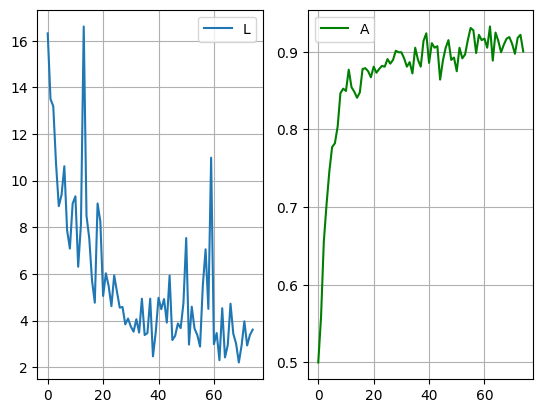

 21%|██        | 82/393 [00:03<00:12, 24.17it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 75] Loss: 2.7372 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 76] Loss: 3.5170 | Acc: 0.9160
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 77] Loss: 2.3187 | Acc: 0.9189
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 78] Loss: 2.0411 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 79] Loss: 3.2249 | Acc: 0.9150
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 80] Loss: 2.4146 | Acc: 0.9248
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 81] Loss: 4.7232 | Acc: 0.8965
torch.Size([8, 128, 384, 384])


 23%|██▎       | 90/393 [00:03<00:10, 29.22it/s]

[Epoch 0 Step 82] Loss: 2.3529 | Acc: 0.9180
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 83] Loss: 3.9600 | Acc: 0.9150
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 84] Loss: 2.7566 | Acc: 0.9082
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 85] Loss: 1.7203 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 86] Loss: 2.3927 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 87] Loss: 2.1293 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 88] Loss: 2.0141 | Acc: 0.9229
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 89] Loss: 2.8465 | Acc: 0.9170


 24%|██▍       | 94/393 [00:03<00:09, 30.18it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 90] Loss: 2.5165 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 91] Loss: 2.3151 | Acc: 0.9141
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 92] Loss: 1.8899 | Acc: 0.9160
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 93] Loss: 1.8761 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 94] Loss: 2.7432 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 95] Loss: 2.2070 | Acc: 0.9189
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 96] Loss: 1.7003 | Acc: 0.9424


 25%|██▍       | 98/393 [00:03<00:09, 30.62it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 97] Loss: 2.3118 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 98] Loss: 1.8343 | Acc: 0.9248
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 99] Loss: 2.3948 | Acc: 0.9199


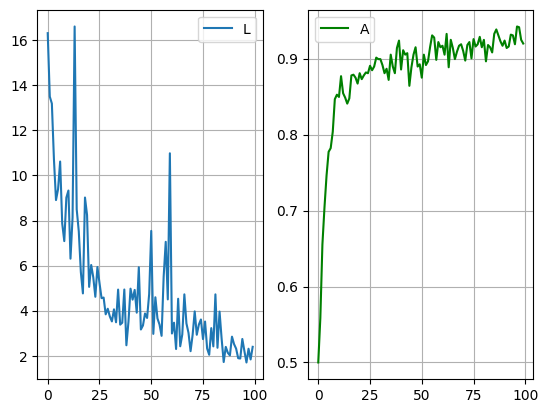

 27%|██▋       | 106/393 [00:04<00:13, 20.66it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 100] Loss: 2.5289 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 101] Loss: 2.0266 | Acc: 0.9170
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 102] Loss: 2.1274 | Acc: 0.9229
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 103] Loss: 2.0002 | Acc: 0.9150
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 104] Loss: 1.6929 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 105] Loss: 1.3158 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 106] Loss: 2.3382 | Acc: 0.9053


 29%|██▉       | 114/393 [00:04<00:10, 25.86it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 107] Loss: 2.0832 | Acc: 0.9229
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 108] Loss: 1.9055 | Acc: 0.9248
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 109] Loss: 1.6994 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 110] Loss: 1.5747 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 111] Loss: 1.9548 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 112] Loss: 1.7006 | Acc: 0.9199
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 113] Loss: 1.7712 | Acc: 0.9189


 30%|███       | 118/393 [00:04<00:09, 27.64it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 114] Loss: 2.2917 | Acc: 0.9219
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 115] Loss: 1.4274 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 116] Loss: 1.7615 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 117] Loss: 1.5614 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 118] Loss: 1.8666 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 119] Loss: 1.7681 | Acc: 0.9268
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 120] Loss: 1.9990 | Acc: 0.9014


 31%|███       | 122/393 [00:04<00:09, 28.77it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 121] Loss: 1.5967 | Acc: 0.9043
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 122] Loss: 2.3389 | Acc: 0.8887
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 123] Loss: 1.6626 | Acc: 0.9033
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 124] Loss: 1.6509 | Acc: 0.9219


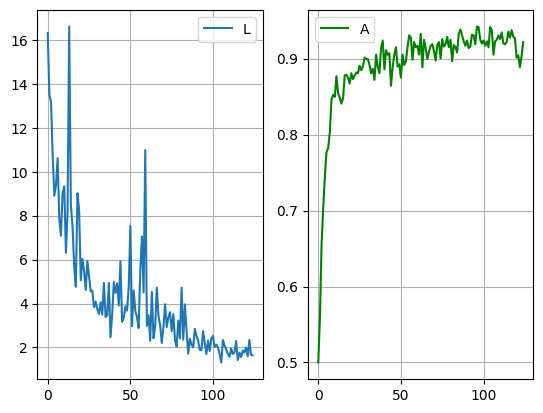

 33%|███▎      | 130/393 [00:05<00:20, 12.88it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 125] Loss: 1.0562 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 126] Loss: 1.4351 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 127] Loss: 1.7677 | Acc: 0.9268
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 128] Loss: 2.1471 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 129] Loss: 1.6737 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 130] Loss: 1.6165 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 131] Loss: 1.6310 | Acc: 0.9141
torch.Size([8, 128, 384, 384])


 35%|███▌      | 138/393 [00:05<00:13, 19.29it/s]

[Epoch 0 Step 132] Loss: 1.5033 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 133] Loss: 2.0336 | Acc: 0.9141
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 134] Loss: 1.5990 | Acc: 0.9229
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 135] Loss: 1.2086 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 136] Loss: 1.7860 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 137] Loss: 1.4167 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 138] Loss: 1.3674 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 139] Loss: 1.7134 | Acc: 0.9248


 37%|███▋      | 146/393 [00:06<00:09, 25.35it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 140] Loss: 1.5395 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 141] Loss: 1.7759 | Acc: 0.9229
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 142] Loss: 2.0301 | Acc: 0.9141
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 143] Loss: 1.7005 | Acc: 0.8994
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 144] Loss: 1.5442 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 145] Loss: 1.9243 | Acc: 0.9248
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 146] Loss: 1.6784 | Acc: 0.9189
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 147] Loss: 2.3850 | Acc: 0.9033
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 148] Loss: 1.4200 | Acc: 0.9189
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 149] Loss: 1.5982 | Acc: 0.9287


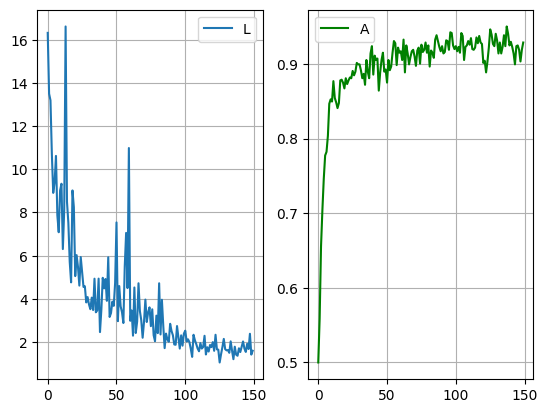

 39%|███▉      | 154/393 [00:06<00:11, 21.40it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 150] Loss: 1.3380 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 151] Loss: 1.7625 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 152] Loss: 1.2004 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 153] Loss: 2.0180 | Acc: 0.9141
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 154] Loss: 1.6558 | Acc: 0.9170
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 155] Loss: 1.8241 | Acc: 0.9268
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 156] Loss: 1.3711 | Acc: 0.9297
torch.Size([8, 128, 384, 384])


 41%|████      | 162/393 [00:06<00:08, 26.80it/s]

[Epoch 0 Step 157] Loss: 1.4369 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 158] Loss: 1.6995 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 159] Loss: 1.3029 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 160] Loss: 1.8130 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 161] Loss: 1.8683 | Acc: 0.9053
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 162] Loss: 1.4643 | Acc: 0.9160
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 163] Loss: 1.2453 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 164] Loss: 1.4476 | Acc: 0.9355


 43%|████▎     | 170/393 [00:07<00:07, 30.92it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 165] Loss: 1.0216 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 166] Loss: 1.4435 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 167] Loss: 1.7833 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 168] Loss: 1.6363 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 169] Loss: 1.3562 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 170] Loss: 1.1450 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 171] Loss: 1.6995 | Acc: 0.9082
torch.Size([8, 128, 384, 384])


 44%|████▍     | 174/393 [00:07<00:06, 32.44it/s]

[Epoch 0 Step 172] Loss: 1.3827 | Acc: 0.9219
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 173] Loss: 1.0520 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 174] Loss: 1.2997 | Acc: 0.9219


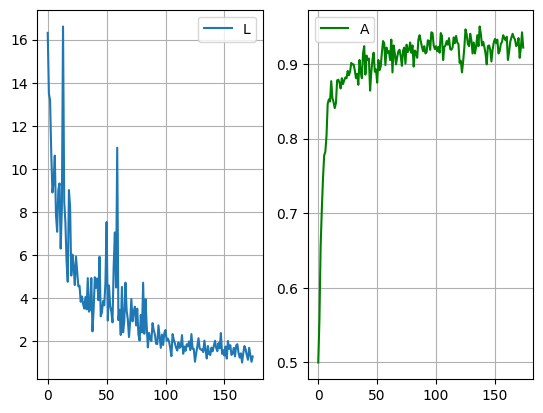

 46%|████▋     | 182/393 [00:07<00:08, 23.71it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 175] Loss: 1.2318 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 176] Loss: 1.4387 | Acc: 0.9209
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 177] Loss: 1.4111 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 178] Loss: 1.3494 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 179] Loss: 1.2838 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 180] Loss: 1.4506 | Acc: 0.9199
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 181] Loss: 1.2121 | Acc: 0.9395
torch.Size([8, 128, 384, 384])


 48%|████▊     | 190/393 [00:07<00:07, 28.89it/s]

[Epoch 0 Step 182] Loss: 1.2750 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 183] Loss: 1.6322 | Acc: 0.9102
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 184] Loss: 1.5489 | Acc: 0.9092
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 185] Loss: 1.1460 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 186] Loss: 2.0479 | Acc: 0.9111
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 187] Loss: 1.3854 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 188] Loss: 1.4638 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 189] Loss: 1.0984 | Acc: 0.9453


 49%|████▉     | 194/393 [00:07<00:06, 30.81it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 190] Loss: 1.8555 | Acc: 0.9229
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 191] Loss: 1.0190 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 192] Loss: 1.2689 | Acc: 0.9219
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 193] Loss: 1.4414 | Acc: 0.9131
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 194] Loss: 1.4518 | Acc: 0.9199
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 195] Loss: 1.1606 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 196] Loss: 1.0583 | Acc: 0.9443
torch.Size([8, 128, 384, 384])


 50%|█████     | 198/393 [00:08<00:06, 32.09it/s]

[Epoch 0 Step 197] Loss: 1.0324 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 198] Loss: 1.0385 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 199] Loss: 1.2227 | Acc: 0.9346


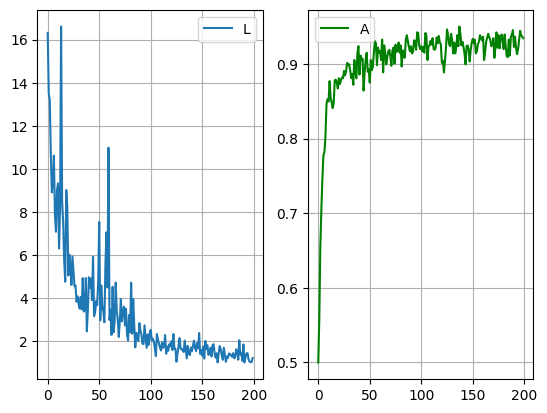

 52%|█████▏    | 206/393 [00:08<00:08, 23.31it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 200] Loss: 0.9105 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 201] Loss: 1.2486 | Acc: 0.9170
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 202] Loss: 0.8177 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 203] Loss: 1.0961 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 204] Loss: 1.0710 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 205] Loss: 1.5485 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 206] Loss: 0.8532 | Acc: 0.9414
torch.Size([8, 128, 384, 384])


 54%|█████▍    | 214/393 [00:08<00:06, 28.62it/s]

[Epoch 0 Step 207] Loss: 1.1348 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 208] Loss: 1.6893 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 209] Loss: 1.1175 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 210] Loss: 0.9440 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 211] Loss: 1.0532 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 212] Loss: 0.9388 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 213] Loss: 1.3533 | Acc: 0.9229
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 214] Loss: 1.0248 | Acc: 0.9297
torch.Size([8, 128, 384, 384])


 56%|█████▋    | 222/393 [00:08<00:05, 32.19it/s]

[Epoch 0 Step 215] Loss: 0.8024 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 216] Loss: 1.5224 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 217] Loss: 1.3317 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 218] Loss: 1.1754 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 219] Loss: 1.3770 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 220] Loss: 1.0149 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 221] Loss: 1.2332 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 222] Loss: 0.7378 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 223] Loss: 1.0296 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 224] Loss: 0.8184 | Acc: 0.9463


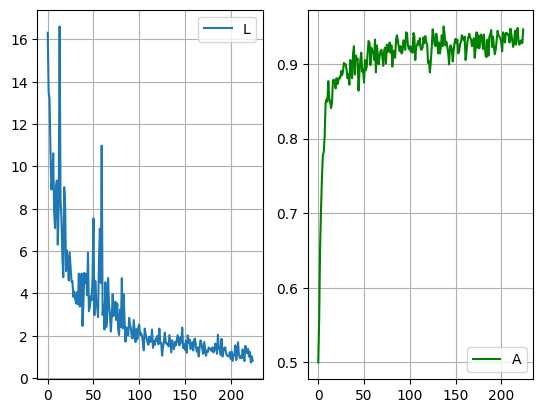

 59%|█████▊    | 230/393 [00:09<00:07, 23.02it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 225] Loss: 1.1370 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 226] Loss: 0.9716 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 227] Loss: 1.1611 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 228] Loss: 1.1754 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 229] Loss: 0.9096 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 230] Loss: 0.7936 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 231] Loss: 1.1795 | Acc: 0.9355
torch.Size([8, 128, 384, 384])


 61%|██████    | 238/393 [00:09<00:05, 28.20it/s]

[Epoch 0 Step 232] Loss: 0.9729 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 233] Loss: 0.7588 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 234] Loss: 1.1474 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 235] Loss: 1.1113 | Acc: 0.9170
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 236] Loss: 1.0376 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 237] Loss: 1.1180 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 238] Loss: 0.8929 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 239] Loss: 1.2311 | Acc: 0.9189


 63%|██████▎   | 246/393 [00:09<00:04, 31.85it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 240] Loss: 0.6643 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 241] Loss: 1.0634 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 242] Loss: 1.2250 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 243] Loss: 1.0217 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 244] Loss: 0.9895 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 245] Loss: 0.6187 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 246] Loss: 1.2268 | Acc: 0.9248
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 247] Loss: 0.9663 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 248] Loss: 1.3426 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 249] Loss: 0.9271 | Acc: 0.9326


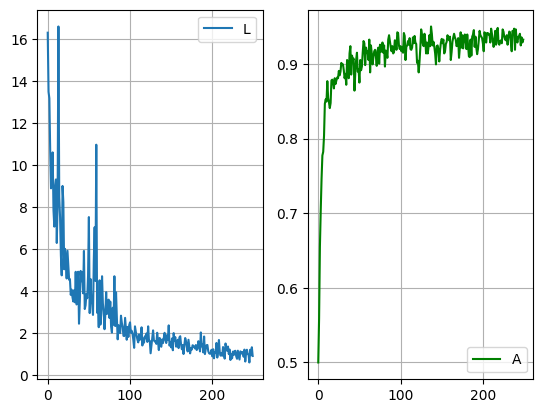

 65%|██████▍   | 254/393 [00:10<00:06, 22.94it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 250] Loss: 1.5495 | Acc: 0.9053
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 251] Loss: 0.9280 | Acc: 0.9209
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 252] Loss: 1.3893 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 253] Loss: 0.6478 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 254] Loss: 1.0821 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 255] Loss: 1.2861 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 256] Loss: 0.9140 | Acc: 0.9385
torch.Size([8, 128, 384, 384])


 67%|██████▋   | 262/393 [00:10<00:04, 28.14it/s]

[Epoch 0 Step 257] Loss: 0.7465 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 258] Loss: 1.1246 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 259] Loss: 0.8087 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 260] Loss: 0.9654 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 261] Loss: 0.9814 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 262] Loss: 0.8966 | Acc: 0.9170
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 263] Loss: 1.0534 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 264] Loss: 0.4843 | Acc: 0.9541


 69%|██████▊   | 270/393 [00:10<00:03, 31.74it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 265] Loss: 0.9505 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 266] Loss: 0.8308 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 267] Loss: 0.8908 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 268] Loss: 1.1258 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 269] Loss: 1.0488 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 270] Loss: 0.7890 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 271] Loss: 0.9399 | Acc: 0.9307
torch.Size([8, 128, 384, 384])


 70%|██████▉   | 274/393 [00:10<00:03, 32.98it/s]

[Epoch 0 Step 272] Loss: 0.6128 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 273] Loss: 0.8574 | Acc: 0.9268
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 274] Loss: 1.3377 | Acc: 0.9316


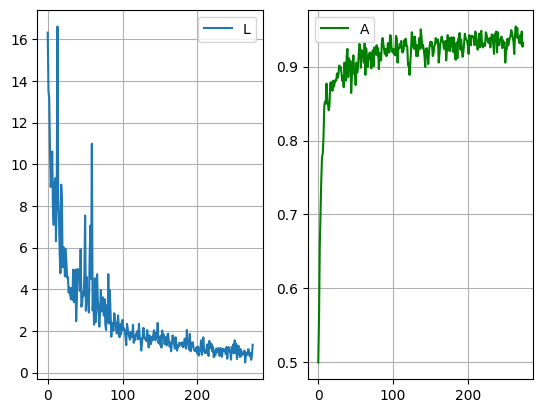

 72%|███████▏  | 282/393 [00:11<00:04, 23.53it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 275] Loss: 1.1536 | Acc: 0.9141
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 276] Loss: 1.1345 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 277] Loss: 0.8841 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 278] Loss: 0.8069 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 279] Loss: 0.8889 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 280] Loss: 0.6816 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 281] Loss: 0.8470 | Acc: 0.9512
torch.Size([8, 128, 384, 384])


 74%|███████▍  | 290/393 [00:11<00:03, 28.78it/s]

[Epoch 0 Step 282] Loss: 1.0282 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 283] Loss: 0.8271 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 284] Loss: 1.0812 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 285] Loss: 0.6065 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 286] Loss: 1.1213 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 287] Loss: 1.0636 | Acc: 0.9189
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 288] Loss: 1.0160 | Acc: 0.9219
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 289] Loss: 0.9217 | Acc: 0.9229
torch.Size([8, 128, 384, 384])


 76%|███████▌  | 298/393 [00:11<00:02, 32.16it/s]

[Epoch 0 Step 290] Loss: 0.9235 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 291] Loss: 0.9769 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 292] Loss: 0.6649 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 293] Loss: 0.9389 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 294] Loss: 0.8782 | Acc: 0.9268
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 295] Loss: 0.7553 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 296] Loss: 0.8707 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 297] Loss: 0.8853 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 298] Loss: 1.0892 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 299] Loss: 1.2088 | Acc: 0.9326


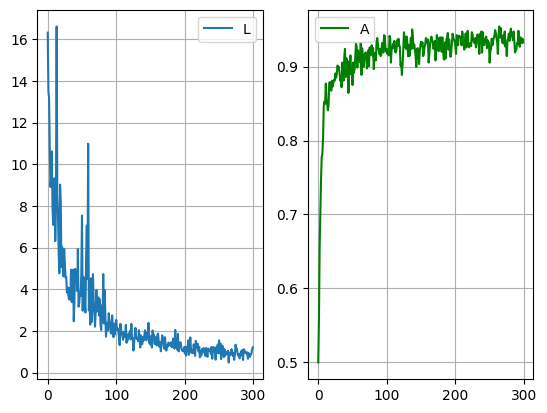

 78%|███████▊  | 306/393 [00:12<00:03, 23.43it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 300] Loss: 0.6225 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 301] Loss: 0.8029 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 302] Loss: 0.6477 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 303] Loss: 0.9389 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 304] Loss: 0.8961 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 305] Loss: 0.8295 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 306] Loss: 1.2950 | Acc: 0.9297
torch.Size([8, 128, 384, 384])


 80%|███████▉  | 314/393 [00:12<00:02, 28.77it/s]

[Epoch 0 Step 307] Loss: 1.0717 | Acc: 0.9121
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 308] Loss: 0.6187 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 309] Loss: 0.6675 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 310] Loss: 0.7436 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 311] Loss: 1.0457 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 312] Loss: 0.8350 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 313] Loss: 1.0505 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 314] Loss: 0.7745 | Acc: 0.9453
torch.Size([8, 128, 384, 384])


 82%|████████▏ | 322/393 [00:12<00:02, 32.30it/s]

[Epoch 0 Step 315] Loss: 0.7693 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 316] Loss: 0.6902 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 317] Loss: 0.8615 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 318] Loss: 0.7250 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 319] Loss: 0.9757 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 320] Loss: 1.0796 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 321] Loss: 0.8367 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 322] Loss: 0.6058 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 323] Loss: 0.6974 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 324] Loss: 0.8361 | Acc: 0.9355


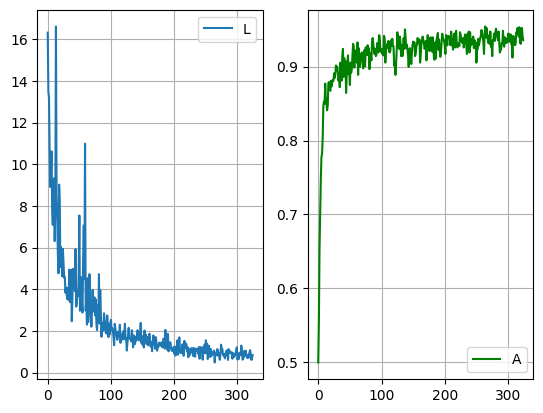

 84%|████████▍ | 330/393 [00:13<00:02, 23.52it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 325] Loss: 0.9810 | Acc: 0.9170
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 326] Loss: 0.6986 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 327] Loss: 0.6203 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 328] Loss: 0.8006 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 329] Loss: 0.9166 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 330] Loss: 0.6206 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 331] Loss: 1.3108 | Acc: 0.9395
torch.Size([8, 128, 384, 384])


 86%|████████▌ | 338/393 [00:13<00:01, 28.82it/s]

[Epoch 0 Step 332] Loss: 0.7949 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 333] Loss: 0.6489 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 334] Loss: 0.6650 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 335] Loss: 0.6769 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 336] Loss: 0.6349 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 337] Loss: 0.8009 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 338] Loss: 0.5595 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 339] Loss: 0.6692 | Acc: 0.9424
torch.Size([8, 128, 384, 384])


 88%|████████▊ | 346/393 [00:13<00:01, 32.31it/s]

[Epoch 0 Step 340] Loss: 0.7484 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 341] Loss: 0.7897 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 342] Loss: 0.6978 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 343] Loss: 0.9530 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 344] Loss: 0.8741 | Acc: 0.9199
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 345] Loss: 0.7971 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 346] Loss: 0.7282 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 347] Loss: 0.7907 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 348] Loss: 0.6954 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 349] Loss: 0.6856 | Acc: 0.9287


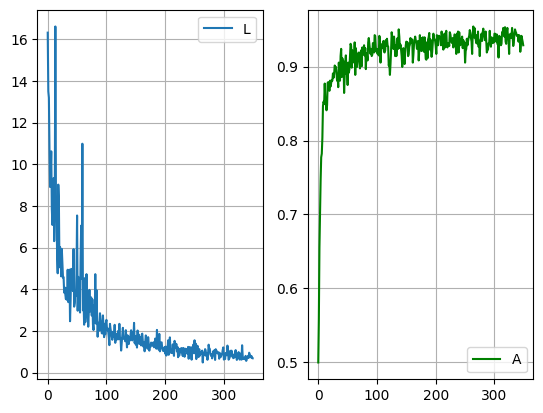

 90%|█████████ | 354/393 [00:14<00:01, 23.41it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 350] Loss: 0.9404 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 351] Loss: 0.7320 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 352] Loss: 0.8000 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 353] Loss: 0.9168 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 354] Loss: 0.7093 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 355] Loss: 0.8779 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 356] Loss: 0.5537 | Acc: 0.9521
torch.Size([8, 128, 384, 384])


 92%|█████████▏| 362/393 [00:14<00:01, 28.66it/s]

[Epoch 0 Step 357] Loss: 0.9549 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 358] Loss: 1.0213 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 359] Loss: 0.6341 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 360] Loss: 0.4001 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 361] Loss: 0.6949 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 362] Loss: 0.8532 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 363] Loss: 1.1084 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 364] Loss: 0.7936 | Acc: 0.9453
torch.Size([8, 128, 384, 384])


 94%|█████████▍| 370/393 [00:14<00:00, 32.39it/s]

[Epoch 0 Step 365] Loss: 1.3378 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 366] Loss: 1.0740 | Acc: 0.9268
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 367] Loss: 0.5750 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 368] Loss: 0.7413 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 369] Loss: 0.5325 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 370] Loss: 0.7813 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 371] Loss: 0.5454 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 372] Loss: 0.6731 | Acc: 0.9336
torch.Size([8, 128, 384, 384])


 95%|█████████▌| 374/393 [00:14<00:00, 33.56it/s]

[Epoch 0 Step 373] Loss: 1.1150 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 374] Loss: 0.8360 | Acc: 0.9443


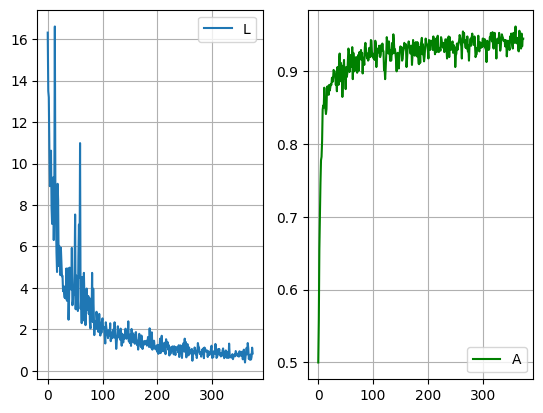

 97%|█████████▋| 382/393 [00:15<00:00, 22.86it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 375] Loss: 0.5563 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 376] Loss: 0.7756 | Acc: 0.9238
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 377] Loss: 0.5760 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 378] Loss: 0.7058 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 379] Loss: 0.6144 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 380] Loss: 0.6353 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 381] Loss: 0.6155 | Acc: 0.9414


 98%|█████████▊| 385/393 [00:15<00:00, 24.10it/s]

torch.Size([8, 128, 384, 384])
[Epoch 0 Step 382] Loss: 0.5466 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 383] Loss: 0.5752 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 384] Loss: 0.7676 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 385] Loss: 0.5802 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 386] Loss: 1.4145 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 387] Loss: 0.9011 | Acc: 0.9404
torch.Size([8, 128, 384, 384])


100%|██████████| 393/393 [00:15<00:00, 25.28it/s]


[Epoch 0 Step 388] Loss: 0.7792 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 389] Loss: 0.8018 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 390] Loss: 0.8084 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 0 Step 391] Loss: 0.7335 | Acc: 0.9346
torch.Size([3, 128, 384, 384])
[Epoch 0 Step 392] Loss: 0.5483 | Acc: 0.9297


  0%|          | 0/393 [00:00<?, ?it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 0] Loss: 0.4545 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 1] Loss: 0.5553 | Acc: 0.9404
torch.Size([8, 128, 384, 384])


  1%|          | 4/393 [00:00<00:11, 34.02it/s]

[Epoch 1 Step 2] Loss: 0.4513 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 3] Loss: 0.6393 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 4] Loss: 1.0587 | Acc: 0.9219
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 5] Loss: 0.5744 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 6] Loss: 0.5051 | Acc: 0.9473


  2%|▏         | 8/393 [00:00<00:11, 34.24it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 7] Loss: 1.0294 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 8] Loss: 0.5462 | Acc: 0.9473
torch.Size([8, 128, 384, 384])


  3%|▎         | 12/393 [00:00<00:11, 34.27it/s]

[Epoch 1 Step 9] Loss: 0.6641 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 10] Loss: 0.6420 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 11] Loss: 1.1577 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 12] Loss: 0.6411 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 13] Loss: 0.3687 | Acc: 0.9482


  4%|▍         | 16/393 [00:00<00:10, 34.31it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 14] Loss: 0.5759 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 15] Loss: 0.6038 | Acc: 0.9326
torch.Size([8, 128, 384, 384])


  5%|▌         | 20/393 [00:00<00:10, 34.28it/s]

[Epoch 1 Step 16] Loss: 0.6384 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 17] Loss: 0.5326 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 18] Loss: 0.8843 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 19] Loss: 0.7997 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 20] Loss: 0.4321 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 21] Loss: 0.5897 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 22] Loss: 0.4577 | Acc: 0.9473
torch.Size([8, 128, 384, 384])


  6%|▌         | 24/393 [00:00<00:11, 33.28it/s]

[Epoch 1 Step 23] Loss: 0.5341 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 24] Loss: 0.8503 | Acc: 0.9316


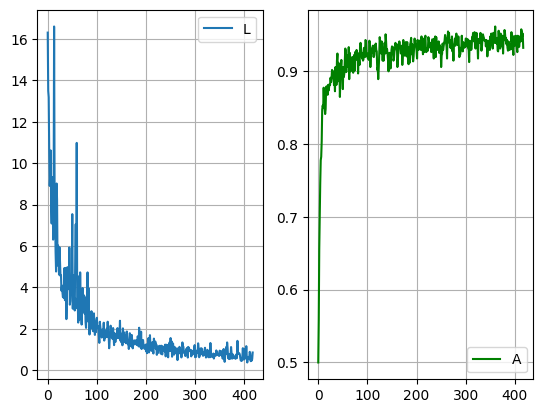

  7%|▋         | 28/393 [00:01<00:21, 16.84it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 25] Loss: 0.5735 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 26] Loss: 0.5949 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 27] Loss: 0.5248 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 28] Loss: 0.5009 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 29] Loss: 0.6045 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 30] Loss: 0.7788 | Acc: 0.9443
torch.Size([8, 128, 384, 384])


  9%|▉         | 36/393 [00:01<00:15, 22.76it/s]

[Epoch 1 Step 31] Loss: 0.5752 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 32] Loss: 0.8153 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 33] Loss: 0.6088 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 34] Loss: 0.6435 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 35] Loss: 0.5987 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 36] Loss: 0.5394 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 37] Loss: 0.5436 | Acc: 0.9443
torch.Size([8, 128, 384, 384])


 11%|█         | 44/393 [00:01<00:12, 27.25it/s]

[Epoch 1 Step 38] Loss: 0.6875 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 39] Loss: 0.4023 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 40] Loss: 0.7137 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 41] Loss: 0.6850 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 42] Loss: 0.4080 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 43] Loss: 0.6524 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 44] Loss: 0.6743 | Acc: 0.9521
torch.Size([8, 128, 384, 384])


 12%|█▏        | 48/393 [00:01<00:11, 29.37it/s]

[Epoch 1 Step 45] Loss: 0.5738 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 46] Loss: 0.5462 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 47] Loss: 0.4753 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 48] Loss: 0.7140 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 49] Loss: 0.7172 | Acc: 0.9482


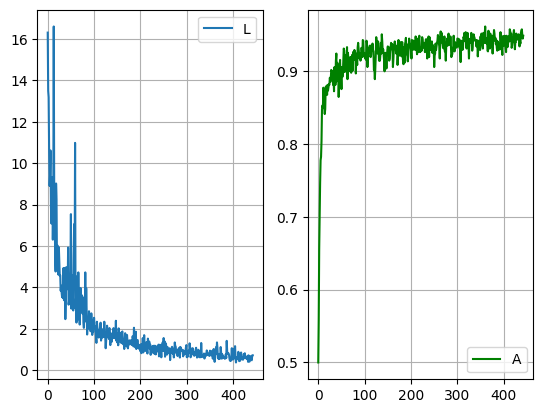

 14%|█▍        | 56/393 [00:02<00:15, 22.11it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 50] Loss: 0.7626 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 51] Loss: 0.6823 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 52] Loss: 0.5619 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 53] Loss: 0.4209 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 54] Loss: 0.7066 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 55] Loss: 0.6322 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 56] Loss: 0.6948 | Acc: 0.9297
torch.Size([8, 128, 384, 384])


 16%|█▋        | 64/393 [00:02<00:11, 27.83it/s]

[Epoch 1 Step 57] Loss: 0.6760 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 58] Loss: 0.4421 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 59] Loss: 0.6593 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 60] Loss: 0.4314 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 61] Loss: 0.7588 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 62] Loss: 0.5858 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 63] Loss: 0.4911 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 64] Loss: 0.5117 | Acc: 0.9531
torch.Size([8, 128, 384, 384])


 18%|█▊        | 72/393 [00:02<00:10, 31.93it/s]

[Epoch 1 Step 65] Loss: 0.2376 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 66] Loss: 0.4325 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 67] Loss: 0.5828 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 68] Loss: 0.6447 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 69] Loss: 1.0127 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 70] Loss: 0.5827 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 71] Loss: 0.5084 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 72] Loss: 0.4153 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 73] Loss: 0.4373 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 74] Loss: 0.5843 | Acc: 0.9443


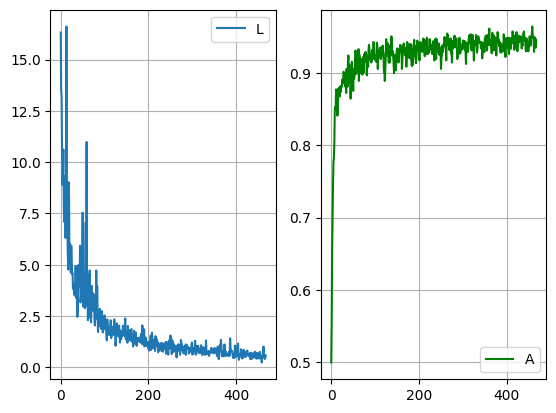

 20%|██        | 80/393 [00:03<00:13, 23.39it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 75] Loss: 0.5894 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 76] Loss: 0.6729 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 77] Loss: 0.5905 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 78] Loss: 0.4435 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 79] Loss: 0.4709 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 80] Loss: 0.5890 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 81] Loss: 0.5161 | Acc: 0.9375
torch.Size([8, 128, 384, 384])


 22%|██▏       | 88/393 [00:03<00:10, 28.63it/s]

[Epoch 1 Step 82] Loss: 0.5515 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 83] Loss: 0.4129 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 84] Loss: 0.4002 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 85] Loss: 0.6446 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 86] Loss: 0.2606 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 87] Loss: 0.5938 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 88] Loss: 0.8639 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 89] Loss: 0.5151 | Acc: 0.9424


 24%|██▍       | 96/393 [00:03<00:09, 32.43it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 90] Loss: 0.3144 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 91] Loss: 0.5208 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 92] Loss: 0.6286 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 93] Loss: 0.2608 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 94] Loss: 0.6638 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 95] Loss: 0.4961 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 96] Loss: 0.6614 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 97] Loss: 0.6664 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 98] Loss: 0.4676 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 99] Loss: 0.7480 | Acc: 0.9307


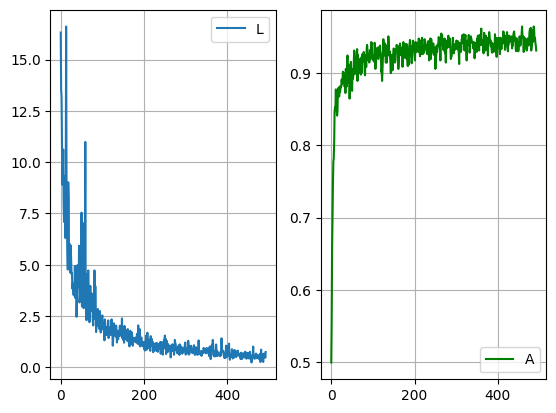

 26%|██▋       | 104/393 [00:04<00:12, 23.95it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 100] Loss: 0.5916 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 101] Loss: 0.4923 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 102] Loss: 0.6201 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 103] Loss: 0.6482 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 104] Loss: 0.4346 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 105] Loss: 0.4173 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 106] Loss: 0.4778 | Acc: 0.9463
torch.Size([8, 128, 384, 384])


 28%|██▊       | 112/393 [00:04<00:09, 29.10it/s]

[Epoch 1 Step 107] Loss: 0.6589 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 108] Loss: 0.5782 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 109] Loss: 0.4198 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 110] Loss: 0.4032 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 111] Loss: 0.3950 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 112] Loss: 0.4677 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 113] Loss: 0.4840 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 114] Loss: 0.6441 | Acc: 0.9375
torch.Size([8, 128, 384, 384])


 31%|███       | 120/393 [00:04<00:08, 32.80it/s]

[Epoch 1 Step 115] Loss: 0.6452 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 116] Loss: 0.5354 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 117] Loss: 0.7462 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 118] Loss: 0.4732 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 119] Loss: 0.9872 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 120] Loss: 0.7553 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 121] Loss: 0.4650 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 122] Loss: 0.4667 | Acc: 0.9482
torch.Size([8, 128, 384, 384])


 32%|███▏      | 124/393 [00:04<00:07, 33.92it/s]

[Epoch 1 Step 123] Loss: 0.7140 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 124] Loss: 0.4002 | Acc: 0.9375


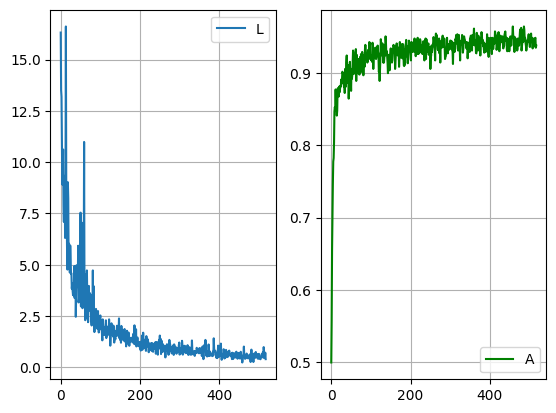

 34%|███▎      | 132/393 [00:05<00:10, 24.05it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 125] Loss: 0.7501 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 126] Loss: 0.6419 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 127] Loss: 0.7453 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 128] Loss: 0.3603 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 129] Loss: 0.4653 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 130] Loss: 0.3693 | Acc: 0.9629
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 131] Loss: 0.3149 | Acc: 0.9551
torch.Size([8, 128, 384, 384])


 36%|███▌      | 140/393 [00:05<00:08, 29.05it/s]

[Epoch 1 Step 132] Loss: 0.2595 | Acc: 0.9668
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 133] Loss: 0.3031 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 134] Loss: 0.5416 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 135] Loss: 0.3719 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 136] Loss: 0.4495 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 137] Loss: 0.5115 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 138] Loss: 0.5121 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 139] Loss: 0.4558 | Acc: 0.9434


 37%|███▋      | 144/393 [00:05<00:08, 30.86it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 140] Loss: 0.6117 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 141] Loss: 0.5889 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 142] Loss: 0.6543 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 143] Loss: 0.5277 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 144] Loss: 0.5124 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 145] Loss: 0.5062 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 146] Loss: 0.5340 | Acc: 0.9365
torch.Size([8, 128, 384, 384])


 38%|███▊      | 148/393 [00:05<00:07, 32.42it/s]

[Epoch 1 Step 147] Loss: 0.4594 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 148] Loss: 0.2977 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 149] Loss: 0.6633 | Acc: 0.9512


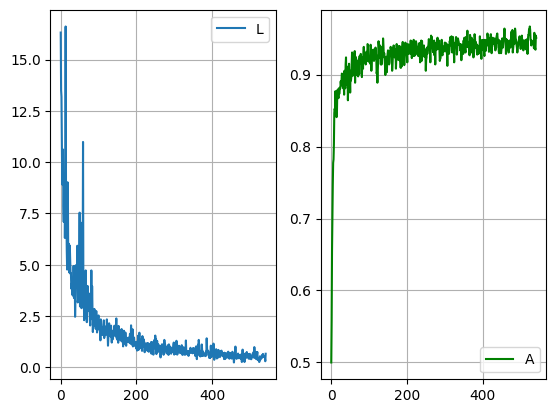

 40%|███▉      | 156/393 [00:06<00:09, 23.73it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 150] Loss: 0.4361 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 151] Loss: 0.3909 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 152] Loss: 0.4346 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 153] Loss: 0.2840 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 154] Loss: 0.4647 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 155] Loss: 0.4599 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 156] Loss: 0.5873 | Acc: 0.9395
torch.Size([8, 128, 384, 384])


 42%|████▏     | 164/393 [00:06<00:07, 29.01it/s]

[Epoch 1 Step 157] Loss: 0.3687 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 158] Loss: 0.5709 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 159] Loss: 0.5440 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 160] Loss: 0.5448 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 161] Loss: 0.3808 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 162] Loss: 0.4952 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 163] Loss: 0.5230 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 164] Loss: 0.3527 | Acc: 0.9580
torch.Size([8, 128, 384, 384])


 44%|████▍     | 172/393 [00:06<00:06, 32.56it/s]

[Epoch 1 Step 165] Loss: 0.4383 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 166] Loss: 0.6881 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 167] Loss: 0.5102 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 168] Loss: 0.3931 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 169] Loss: 0.5744 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 170] Loss: 0.3121 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 171] Loss: 0.4646 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 172] Loss: 0.5677 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 173] Loss: 0.3684 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 174] Loss: 0.4385 | Acc: 0.9443


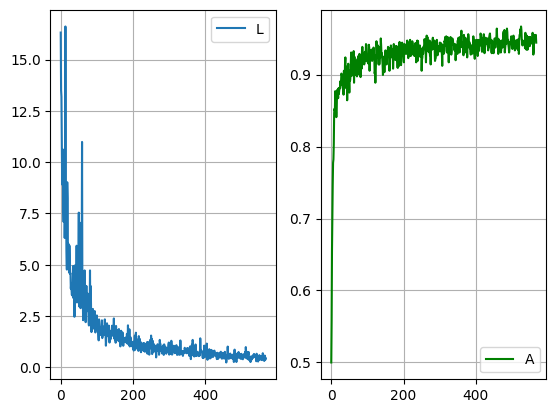

 46%|████▌     | 180/393 [00:06<00:08, 23.76it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 175] Loss: 0.4395 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 176] Loss: 0.3487 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 177] Loss: 0.3519 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 178] Loss: 0.7745 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 179] Loss: 0.3301 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 180] Loss: 0.4802 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 181] Loss: 0.5125 | Acc: 0.9463
torch.Size([8, 128, 384, 384])


 48%|████▊     | 188/393 [00:07<00:07, 28.99it/s]

[Epoch 1 Step 182] Loss: 0.3091 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 183] Loss: 0.4001 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 184] Loss: 0.5145 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 185] Loss: 0.3573 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 186] Loss: 0.4297 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 187] Loss: 0.4104 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 188] Loss: 0.4393 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 189] Loss: 0.4131 | Acc: 0.9404
torch.Size([8, 128, 384, 384])


 50%|████▉     | 196/393 [00:07<00:06, 32.41it/s]

[Epoch 1 Step 190] Loss: 0.4960 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 191] Loss: 0.2998 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 192] Loss: 0.5126 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 193] Loss: 0.5423 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 194] Loss: 0.3674 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 195] Loss: 0.4468 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 196] Loss: 0.3262 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 197] Loss: 0.4173 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 198] Loss: 0.7000 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 199] Loss: 0.3739 | Acc: 0.9512


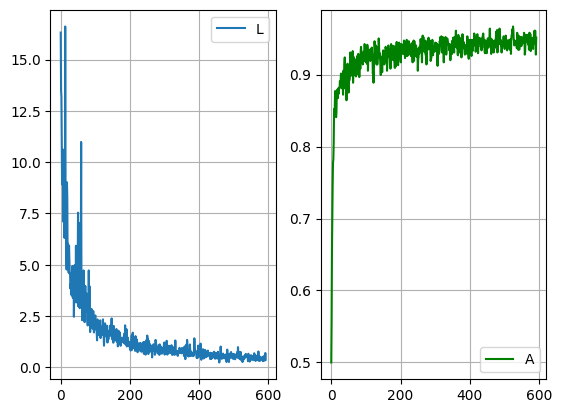

 52%|█████▏    | 204/393 [00:07<00:07, 23.79it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 200] Loss: 0.5139 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 201] Loss: 0.6792 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 202] Loss: 0.4607 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 203] Loss: 0.5958 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 204] Loss: 0.4378 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 205] Loss: 0.4982 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 206] Loss: 0.5150 | Acc: 0.9443
torch.Size([8, 128, 384, 384])


 54%|█████▍    | 212/393 [00:08<00:06, 29.16it/s]

[Epoch 1 Step 207] Loss: 0.6419 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 208] Loss: 0.6893 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 209] Loss: 0.5357 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 210] Loss: 0.5896 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 211] Loss: 0.4032 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 212] Loss: 0.4742 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 213] Loss: 0.6228 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 214] Loss: 0.4855 | Acc: 0.9404


 56%|█████▌    | 220/393 [00:08<00:05, 32.52it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 215] Loss: 0.4654 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 216] Loss: 0.8440 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 217] Loss: 0.4841 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 218] Loss: 0.6902 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 219] Loss: 0.6051 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 220] Loss: 0.5020 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 221] Loss: 0.5873 | Acc: 0.9453
torch.Size([8, 128, 384, 384])


 57%|█████▋    | 224/393 [00:08<00:05, 33.60it/s]

[Epoch 1 Step 222] Loss: 0.3354 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 223] Loss: 0.4627 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 224] Loss: 0.5475 | Acc: 0.9248


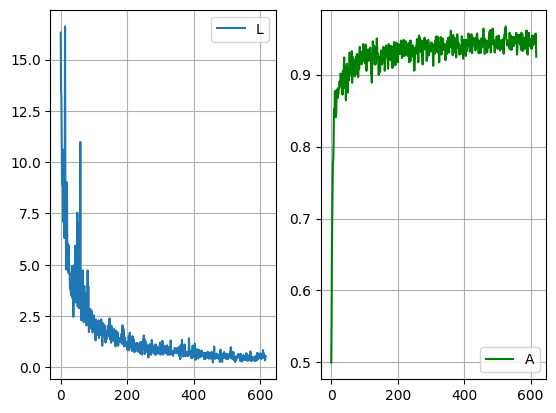

 59%|█████▉    | 232/393 [00:08<00:06, 23.97it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 225] Loss: 0.4859 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 226] Loss: 0.8399 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 227] Loss: 0.4555 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 228] Loss: 0.5411 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 229] Loss: 0.3461 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 230] Loss: 0.6606 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 231] Loss: 0.5153 | Acc: 0.9326
torch.Size([8, 128, 384, 384])


 61%|██████    | 240/393 [00:09<00:05, 29.35it/s]

[Epoch 1 Step 232] Loss: 0.3217 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 233] Loss: 0.7157 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 234] Loss: 0.7119 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 235] Loss: 0.6335 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 236] Loss: 0.5865 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 237] Loss: 0.4980 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 238] Loss: 0.3763 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 239] Loss: 0.7572 | Acc: 0.9375
torch.Size([8, 128, 384, 384])


 63%|██████▎   | 248/393 [00:09<00:04, 32.07it/s]

[Epoch 1 Step 240] Loss: 0.4094 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 241] Loss: 0.7342 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 242] Loss: 0.4580 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 243] Loss: 0.5296 | Acc: 0.9248
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 244] Loss: 0.3768 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 245] Loss: 0.5825 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 246] Loss: 0.4838 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 247] Loss: 0.5511 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 248] Loss: 0.4930 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 249] Loss: 0.5226 | Acc: 0.9473


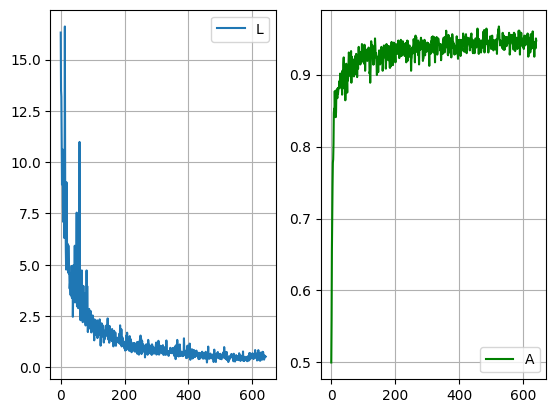

 65%|██████▌   | 256/393 [00:09<00:05, 23.29it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 250] Loss: 0.3220 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 251] Loss: 0.4137 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 252] Loss: 0.6308 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 253] Loss: 0.3336 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 254] Loss: 0.5106 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 255] Loss: 0.7012 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 256] Loss: 0.3509 | Acc: 0.9570
torch.Size([8, 128, 384, 384])


 67%|██████▋   | 264/393 [00:09<00:04, 28.70it/s]

[Epoch 1 Step 257] Loss: 0.4370 | Acc: 0.9629
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 258] Loss: 0.6766 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 259] Loss: 0.4439 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 260] Loss: 0.7325 | Acc: 0.9229
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 261] Loss: 0.4695 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 262] Loss: 0.5925 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 263] Loss: 0.5450 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 264] Loss: 0.4532 | Acc: 0.9512
torch.Size([8, 128, 384, 384])


 69%|██████▉   | 272/393 [00:10<00:03, 32.22it/s]

[Epoch 1 Step 265] Loss: 0.6465 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 266] Loss: 0.4173 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 267] Loss: 0.4409 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 268] Loss: 0.5651 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 269] Loss: 0.5564 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 270] Loss: 0.4796 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 271] Loss: 0.4522 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 272] Loss: 0.5487 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 273] Loss: 0.6394 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 274] Loss: 0.3941 | Acc: 0.9414


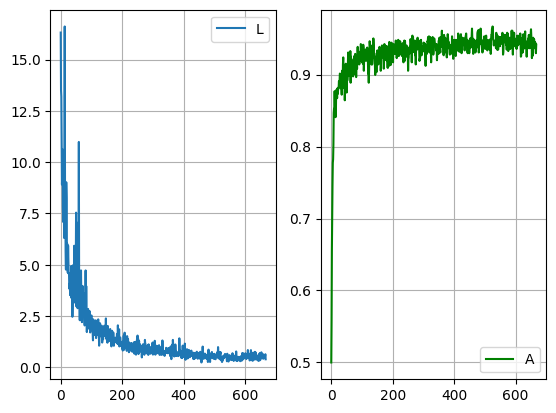

 71%|███████   | 280/393 [00:10<00:04, 23.72it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 275] Loss: 0.4219 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 276] Loss: 0.5462 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 277] Loss: 0.4235 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 278] Loss: 0.3252 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 279] Loss: 0.2194 | Acc: 0.9707
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 280] Loss: 0.4488 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 281] Loss: 0.4747 | Acc: 0.9512
torch.Size([8, 128, 384, 384])


 73%|███████▎  | 288/393 [00:10<00:03, 29.08it/s]

[Epoch 1 Step 282] Loss: 0.5463 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 283] Loss: 0.6362 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 284] Loss: 0.3968 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 285] Loss: 0.4699 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 286] Loss: 0.4999 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 287] Loss: 0.7386 | Acc: 0.9209
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 288] Loss: 0.4200 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 289] Loss: 0.3149 | Acc: 0.9590
torch.Size([8, 128, 384, 384])


 75%|███████▌  | 296/393 [00:11<00:02, 32.74it/s]

[Epoch 1 Step 290] Loss: 0.3535 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 291] Loss: 0.3881 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 292] Loss: 0.5629 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 293] Loss: 0.4172 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 294] Loss: 0.4799 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 295] Loss: 0.3688 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 296] Loss: 0.5404 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 297] Loss: 0.5672 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 298] Loss: 0.4487 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 299] Loss: 0.5091 | Acc: 0.9443


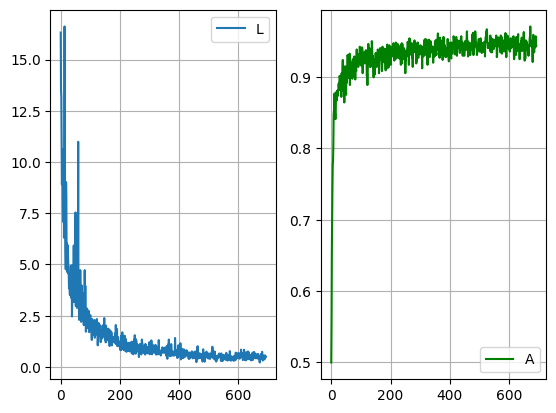

 77%|███████▋  | 304/393 [00:11<00:03, 23.53it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 300] Loss: 0.4504 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 301] Loss: 0.4962 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 302] Loss: 0.5793 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 303] Loss: 0.3520 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 304] Loss: 0.3014 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 305] Loss: 0.2967 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 306] Loss: 0.5650 | Acc: 0.9287
torch.Size([8, 128, 384, 384])


 79%|███████▉  | 312/393 [00:11<00:02, 28.35it/s]

[Epoch 1 Step 307] Loss: 0.5286 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 308] Loss: 0.2233 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 309] Loss: 0.5028 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 310] Loss: 0.3660 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 311] Loss: 0.4352 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 312] Loss: 0.3975 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 313] Loss: 0.7012 | Acc: 0.9375
torch.Size([8, 128, 384, 384])


 81%|████████▏ | 320/393 [00:12<00:02, 30.58it/s]

[Epoch 1 Step 314] Loss: 0.3855 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 315] Loss: 0.1912 | Acc: 0.9678
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 316] Loss: 0.3197 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 317] Loss: 0.4043 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 318] Loss: 0.3430 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 319] Loss: 0.3645 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 320] Loss: 0.2812 | Acc: 0.9521


 82%|████████▏ | 324/393 [00:12<00:02, 31.00it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 321] Loss: 0.4775 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 322] Loss: 0.4055 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 323] Loss: 0.4160 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 324] Loss: 0.5441 | Acc: 0.9355


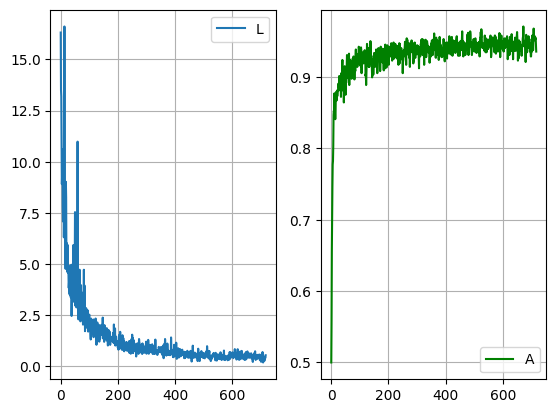

 84%|████████▍ | 332/393 [00:12<00:02, 20.91it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 325] Loss: 0.3501 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 326] Loss: 0.4288 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 327] Loss: 0.4600 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 328] Loss: 0.3624 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 329] Loss: 0.5863 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 330] Loss: 0.4962 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 331] Loss: 0.1990 | Acc: 0.9619


 85%|████████▌ | 336/393 [00:12<00:02, 23.71it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 332] Loss: 0.4906 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 333] Loss: 0.7534 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 334] Loss: 0.6358 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 335] Loss: 0.5318 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 336] Loss: 0.3196 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 337] Loss: 0.2587 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 338] Loss: 0.4885 | Acc: 0.9287
torch.Size([8, 128, 384, 384])


 88%|████████▊ | 344/393 [00:13<00:01, 28.33it/s]

[Epoch 1 Step 339] Loss: 0.4545 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 340] Loss: 0.3390 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 341] Loss: 0.1765 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 342] Loss: 0.3389 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 343] Loss: 0.4356 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 344] Loss: 0.5490 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 345] Loss: 0.6799 | Acc: 0.9365
torch.Size([8, 128, 384, 384])


 89%|████████▊ | 348/393 [00:13<00:01, 28.61it/s]

[Epoch 1 Step 346] Loss: 0.4290 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 347] Loss: 0.4749 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 348] Loss: 0.3139 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 349] Loss: 0.4031 | Acc: 0.9395


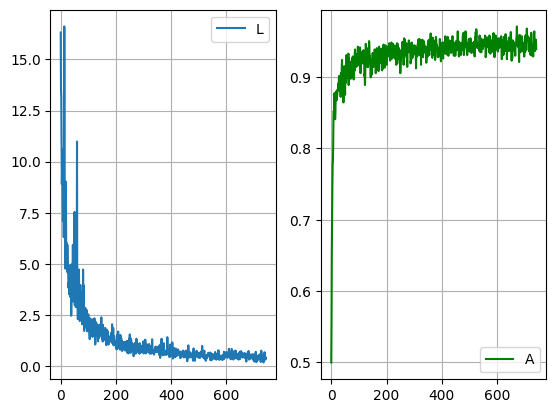

 91%|█████████ | 356/393 [00:13<00:01, 19.46it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 350] Loss: 0.3036 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 351] Loss: 0.6100 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 352] Loss: 0.4145 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 353] Loss: 0.3995 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 354] Loss: 0.4463 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 355] Loss: 0.3163 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 356] Loss: 0.3206 | Acc: 0.9531


 93%|█████████▎| 364/393 [00:14<00:01, 25.70it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 357] Loss: 0.3751 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 358] Loss: 0.2450 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 359] Loss: 0.2438 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 360] Loss: 0.5721 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 361] Loss: 0.3700 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 362] Loss: 0.4580 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 363] Loss: 0.4573 | Acc: 0.9473
torch.Size([8, 128, 384, 384])


 95%|█████████▍| 372/393 [00:14<00:00, 30.34it/s]

[Epoch 1 Step 364] Loss: 0.5371 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 365] Loss: 0.3614 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 366] Loss: 0.3335 | Acc: 0.9668
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 367] Loss: 0.4704 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 368] Loss: 0.3648 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 369] Loss: 0.5787 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 370] Loss: 0.2246 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 371] Loss: 0.5893 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 372] Loss: 0.3258 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 373] Loss: 0.4341 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 374] Loss: 0.5384 | Acc: 0.9404


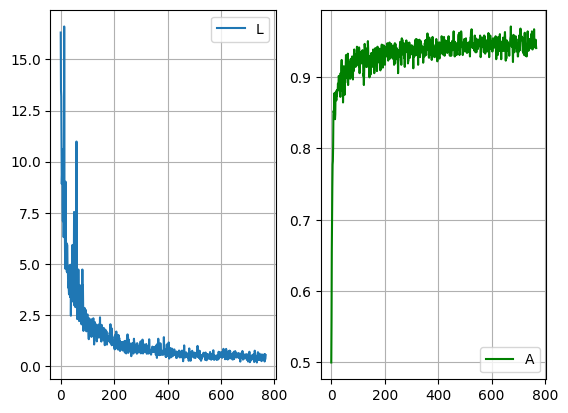

 97%|█████████▋| 380/393 [00:14<00:00, 22.38it/s]

torch.Size([8, 128, 384, 384])
[Epoch 1 Step 375] Loss: 0.3227 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 376] Loss: 0.4582 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 377] Loss: 0.4030 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 378] Loss: 0.4079 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 379] Loss: 0.5452 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 380] Loss: 0.7142 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 381] Loss: 0.5450 | Acc: 0.9395
torch.Size([8, 128, 384, 384])


 99%|█████████▊| 388/393 [00:14<00:00, 27.95it/s]

[Epoch 1 Step 382] Loss: 0.4761 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 383] Loss: 0.5181 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 384] Loss: 0.4632 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 385] Loss: 0.4785 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 386] Loss: 0.6265 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 387] Loss: 0.2795 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 388] Loss: 0.7027 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 389] Loss: 0.3391 | Acc: 0.9541
torch.Size([8, 128, 384, 384])


100%|██████████| 393/393 [00:15<00:00, 26.07it/s]


[Epoch 1 Step 390] Loss: 0.3205 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 1 Step 391] Loss: 0.2928 | Acc: 0.9512
torch.Size([3, 128, 384, 384])
[Epoch 1 Step 392] Loss: 0.5963 | Acc: 0.9505


  1%|          | 4/393 [00:00<00:11, 35.10it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 0] Loss: 0.3576 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 1] Loss: 0.3151 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 2] Loss: 0.6227 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 3] Loss: 0.4521 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 4] Loss: 0.5043 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 5] Loss: 0.3459 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 6] Loss: 0.5314 | Acc: 0.9414
torch.Size([8, 128, 384, 384])


  3%|▎         | 12/393 [00:00<00:10, 35.95it/s]

[Epoch 2 Step 7] Loss: 0.6917 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 8] Loss: 0.5594 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 9] Loss: 0.3875 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 10] Loss: 0.4199 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 11] Loss: 0.4790 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 12] Loss: 0.3010 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 13] Loss: 0.4155 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 14] Loss: 0.4889 | Acc: 0.9512


  5%|▌         | 20/393 [00:00<00:10, 36.60it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 15] Loss: 0.5430 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 16] Loss: 0.8673 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 17] Loss: 0.4786 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 18] Loss: 0.5795 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 19] Loss: 0.5144 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 20] Loss: 0.2623 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 21] Loss: 0.3386 | Acc: 0.9395
torch.Size([8, 128, 384, 384])


  6%|▌         | 24/393 [00:00<00:10, 36.36it/s]

[Epoch 2 Step 22] Loss: 0.7480 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 23] Loss: 0.6703 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 24] Loss: 0.4197 | Acc: 0.9482


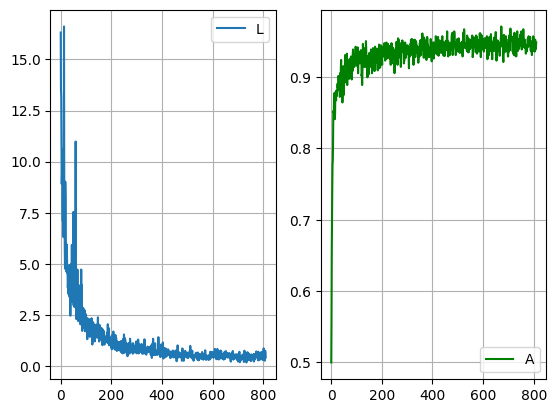

  8%|▊         | 32/393 [00:01<00:15, 23.75it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 25] Loss: 0.4779 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 26] Loss: 0.2935 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 27] Loss: 0.3706 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 28] Loss: 0.4549 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 29] Loss: 0.2410 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 30] Loss: 0.7048 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 31] Loss: 0.3818 | Acc: 0.9531
torch.Size([8, 128, 384, 384])


 10%|█         | 40/393 [00:01<00:12, 29.11it/s]

[Epoch 2 Step 32] Loss: 0.4209 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 33] Loss: 0.5119 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 34] Loss: 0.4387 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 35] Loss: 0.4775 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 36] Loss: 0.3586 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 37] Loss: 0.2413 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 38] Loss: 0.3761 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 39] Loss: 0.4670 | Acc: 0.9395
torch.Size([8, 128, 384, 384])


 12%|█▏        | 48/393 [00:01<00:10, 32.53it/s]

[Epoch 2 Step 40] Loss: 0.4291 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 41] Loss: 0.4374 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 42] Loss: 0.4328 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 43] Loss: 0.1714 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 44] Loss: 0.4927 | Acc: 0.9629
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 45] Loss: 0.3239 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 46] Loss: 0.4437 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 47] Loss: 0.3523 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 48] Loss: 0.4319 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 49] Loss: 0.3795 | Acc: 0.9541


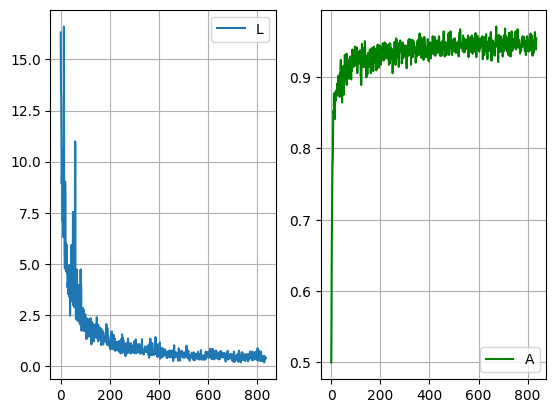

 14%|█▍        | 56/393 [00:02<00:14, 23.30it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 50] Loss: 0.1829 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 51] Loss: 0.3100 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 52] Loss: 0.2885 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 53] Loss: 0.3825 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 54] Loss: 0.4481 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 55] Loss: 0.4281 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 56] Loss: 0.3400 | Acc: 0.9492
torch.Size([8, 128, 384, 384])


 16%|█▋        | 64/393 [00:02<00:11, 28.64it/s]

[Epoch 2 Step 57] Loss: 0.3608 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 58] Loss: 0.3473 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 59] Loss: 0.4195 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 60] Loss: 0.4008 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 61] Loss: 0.3678 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 62] Loss: 0.2550 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 63] Loss: 0.4369 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 64] Loss: 0.5855 | Acc: 0.9434
torch.Size([8, 128, 384, 384])


 18%|█▊        | 72/393 [00:02<00:10, 32.01it/s]

[Epoch 2 Step 65] Loss: 0.3176 | Acc: 0.9658
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 66] Loss: 0.5152 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 67] Loss: 0.5234 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 68] Loss: 0.2963 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 69] Loss: 0.3259 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 70] Loss: 0.2601 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 71] Loss: 0.3446 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 72] Loss: 0.5060 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 73] Loss: 0.5605 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 74] Loss: 0.4473 | Acc: 0.9434


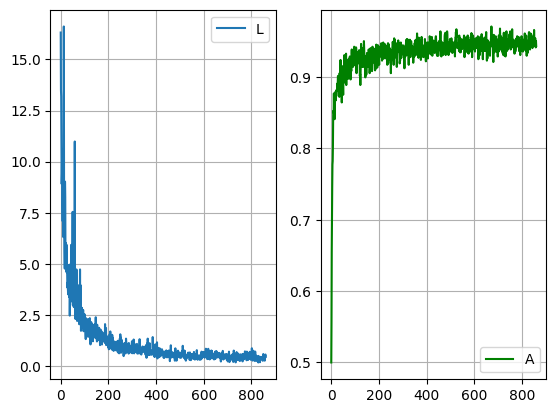

 20%|██        | 80/393 [00:02<00:13, 23.18it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 75] Loss: 0.4313 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 76] Loss: 0.4661 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 77] Loss: 0.4297 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 78] Loss: 0.3457 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 79] Loss: 0.4035 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 80] Loss: 0.3251 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 81] Loss: 0.4590 | Acc: 0.9551
torch.Size([8, 128, 384, 384])


 22%|██▏       | 88/393 [00:03<00:10, 28.44it/s]

[Epoch 2 Step 82] Loss: 0.4008 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 83] Loss: 0.3430 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 84] Loss: 0.4044 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 85] Loss: 0.3160 | Acc: 0.9688
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 86] Loss: 0.2756 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 87] Loss: 0.4994 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 88] Loss: 0.3271 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 89] Loss: 0.2245 | Acc: 0.9561
torch.Size([8, 128, 384, 384])


 24%|██▍       | 96/393 [00:03<00:09, 31.89it/s]

[Epoch 2 Step 90] Loss: 0.4884 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 91] Loss: 0.4282 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 92] Loss: 0.3134 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 93] Loss: 0.2600 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 94] Loss: 0.4950 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 95] Loss: 0.4192 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 96] Loss: 0.3438 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 97] Loss: 0.5892 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 98] Loss: 0.5667 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 99] Loss: 0.3479 | Acc: 0.9463


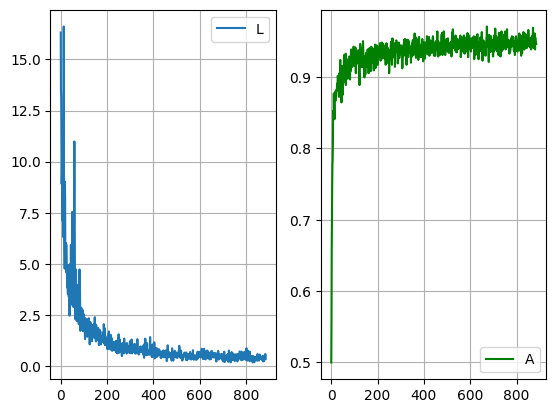

 26%|██▋       | 104/393 [00:03<00:12, 23.44it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 100] Loss: 0.3407 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 101] Loss: 0.2314 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 102] Loss: 0.4024 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 103] Loss: 0.4487 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 104] Loss: 0.3950 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 105] Loss: 0.3274 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 106] Loss: 0.5137 | Acc: 0.9395
torch.Size([8, 128, 384, 384])


 28%|██▊       | 112/393 [00:04<00:09, 28.65it/s]

[Epoch 2 Step 107] Loss: 0.4700 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 108] Loss: 0.2822 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 109] Loss: 0.4704 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 110] Loss: 0.4000 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 111] Loss: 0.3251 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 112] Loss: 0.4497 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 113] Loss: 0.4888 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 114] Loss: 0.3191 | Acc: 0.9561
torch.Size([8, 128, 384, 384])


 31%|███       | 120/393 [00:04<00:08, 32.34it/s]

[Epoch 2 Step 115] Loss: 0.8536 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 116] Loss: 0.4480 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 117] Loss: 0.4502 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 118] Loss: 0.4003 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 119] Loss: 0.3053 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 120] Loss: 0.5162 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 121] Loss: 0.3346 | Acc: 0.9648
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 122] Loss: 0.4525 | Acc: 0.9551


 32%|███▏      | 124/393 [00:04<00:08, 32.97it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 123] Loss: 0.4535 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 124] Loss: 0.3596 | Acc: 0.9502


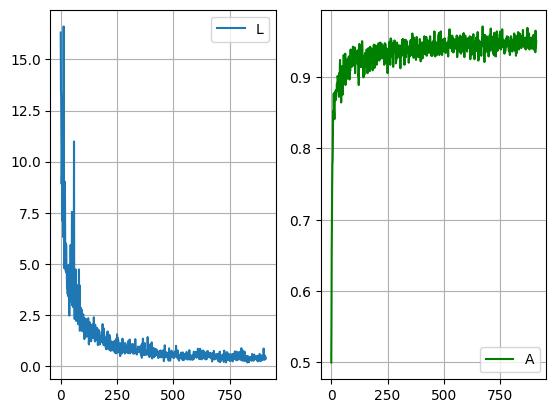

 34%|███▎      | 132/393 [00:04<00:10, 23.76it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 125] Loss: 0.5082 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 126] Loss: 0.4491 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 127] Loss: 0.3583 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 128] Loss: 0.3522 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 129] Loss: 0.2859 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 130] Loss: 0.3970 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 131] Loss: 0.2882 | Acc: 0.9590
torch.Size([8, 128, 384, 384])


 36%|███▌      | 140/393 [00:05<00:08, 28.98it/s]

[Epoch 2 Step 132] Loss: 0.5255 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 133] Loss: 0.3482 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 134] Loss: 0.4296 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 135] Loss: 0.3797 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 136] Loss: 0.5068 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 137] Loss: 0.3564 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 138] Loss: 0.4728 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 139] Loss: 0.3744 | Acc: 0.9375
torch.Size([8, 128, 384, 384])


 38%|███▊      | 148/393 [00:05<00:07, 32.49it/s]

[Epoch 2 Step 140] Loss: 0.3581 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 141] Loss: 0.3015 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 142] Loss: 0.5507 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 143] Loss: 0.3853 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 144] Loss: 0.5475 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 145] Loss: 0.4356 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 146] Loss: 0.5453 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 147] Loss: 0.4824 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 148] Loss: 0.2623 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 149] Loss: 0.3890 | Acc: 0.9375


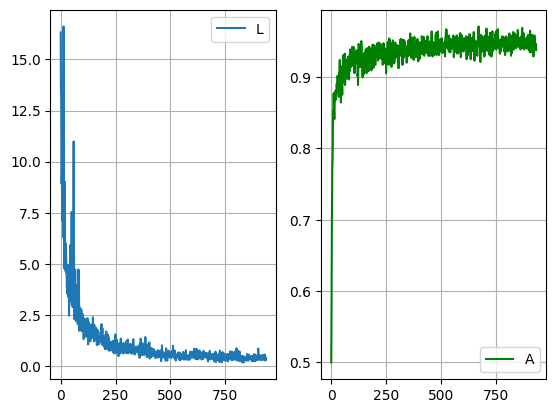

 40%|███▉      | 156/393 [00:05<00:10, 23.07it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 150] Loss: 0.3169 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 151] Loss: 0.3833 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 152] Loss: 0.3549 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 153] Loss: 0.5012 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 154] Loss: 0.5343 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 155] Loss: 0.4169 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 156] Loss: 0.5194 | Acc: 0.9404
torch.Size([8, 128, 384, 384])


 42%|████▏     | 164/393 [00:06<00:08, 28.24it/s]

[Epoch 2 Step 157] Loss: 0.5421 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 158] Loss: 0.4727 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 159] Loss: 0.2004 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 160] Loss: 0.4243 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 161] Loss: 0.3527 | Acc: 0.9648
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 162] Loss: 0.3303 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 163] Loss: 0.3467 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 164] Loss: 0.5519 | Acc: 0.9512


 44%|████▍     | 172/393 [00:06<00:06, 32.11it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 165] Loss: 0.4456 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 166] Loss: 0.3127 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 167] Loss: 0.3757 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 168] Loss: 0.3270 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 169] Loss: 0.4211 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 170] Loss: 0.3624 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 171] Loss: 0.6813 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 172] Loss: 0.4141 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 173] Loss: 0.3164 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 174] Loss: 0.4217 | Acc: 0.9590


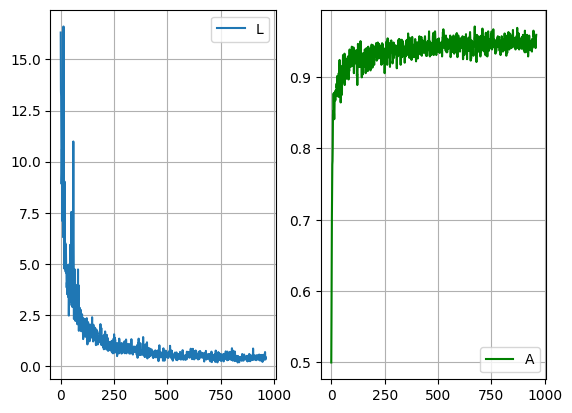

 46%|████▌     | 180/393 [00:06<00:09, 22.55it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 175] Loss: 0.2953 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 176] Loss: 0.2117 | Acc: 0.9648
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 177] Loss: 0.5361 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 178] Loss: 0.1851 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 179] Loss: 0.4811 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 180] Loss: 0.4159 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 181] Loss: 0.4637 | Acc: 0.9570
torch.Size([8, 128, 384, 384])


 48%|████▊     | 188/393 [00:07<00:07, 28.09it/s]

[Epoch 2 Step 182] Loss: 0.4143 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 183] Loss: 0.3577 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 184] Loss: 0.3240 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 185] Loss: 0.2796 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 186] Loss: 0.7274 | Acc: 0.9258
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 187] Loss: 0.2746 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 188] Loss: 0.2903 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 189] Loss: 0.3004 | Acc: 0.9619
torch.Size([8, 128, 384, 384])


 50%|████▉     | 196/393 [00:07<00:06, 31.92it/s]

[Epoch 2 Step 190] Loss: 0.5708 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 191] Loss: 0.4537 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 192] Loss: 0.4028 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 193] Loss: 0.2586 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 194] Loss: 0.4767 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 195] Loss: 0.3502 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 196] Loss: 0.3444 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 197] Loss: 0.3350 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 198] Loss: 0.3570 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 199] Loss: 0.6195 | Acc: 0.9404


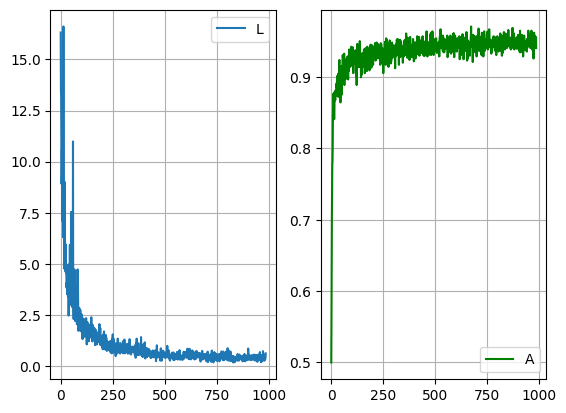

 52%|█████▏    | 204/393 [00:07<00:08, 23.32it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 200] Loss: 0.3972 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 201] Loss: 0.2989 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 202] Loss: 0.4600 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 203] Loss: 0.4832 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 204] Loss: 0.3129 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 205] Loss: 0.4323 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 206] Loss: 0.3956 | Acc: 0.9492
torch.Size([8, 128, 384, 384])


 54%|█████▍    | 212/393 [00:07<00:06, 28.52it/s]

[Epoch 2 Step 207] Loss: 0.6283 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 208] Loss: 0.3246 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 209] Loss: 0.4124 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 210] Loss: 0.4102 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 211] Loss: 0.4561 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 212] Loss: 0.2958 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 213] Loss: 0.4177 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 214] Loss: 0.5384 | Acc: 0.9395
torch.Size([8, 128, 384, 384])


 56%|█████▌    | 220/393 [00:08<00:05, 32.27it/s]

[Epoch 2 Step 215] Loss: 0.4930 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 216] Loss: 0.2442 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 217] Loss: 0.3089 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 218] Loss: 0.3398 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 219] Loss: 0.3050 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 220] Loss: 0.4752 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 221] Loss: 0.4165 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 222] Loss: 0.3220 | Acc: 0.9521
torch.Size([8, 128, 384, 384])


 57%|█████▋    | 224/393 [00:08<00:05, 33.31it/s]

[Epoch 2 Step 223] Loss: 0.2810 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 224] Loss: 0.3970 | Acc: 0.9316


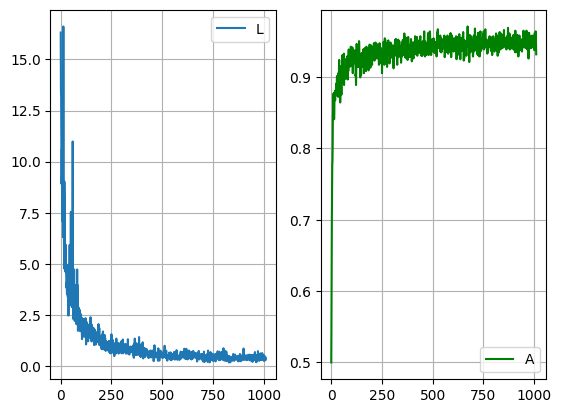

 59%|█████▉    | 232/393 [00:08<00:06, 23.52it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 225] Loss: 0.3684 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 226] Loss: 0.4419 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 227] Loss: 0.3183 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 228] Loss: 0.3831 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 229] Loss: 0.3651 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 230] Loss: 0.3425 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 231] Loss: 0.3989 | Acc: 0.9580
torch.Size([8, 128, 384, 384])


 60%|██████    | 236/393 [00:08<00:06, 25.59it/s]

[Epoch 2 Step 232] Loss: 0.4887 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 233] Loss: 0.2819 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 234] Loss: 0.4242 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 235] Loss: 0.3927 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 236] Loss: 0.4281 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 237] Loss: 0.4227 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 238] Loss: 0.4025 | Acc: 0.9463
torch.Size([8, 128, 384, 384])


 62%|██████▏   | 244/393 [00:09<00:05, 28.56it/s]

[Epoch 2 Step 239] Loss: 0.3466 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 240] Loss: 0.4174 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 241] Loss: 0.2983 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 242] Loss: 0.3622 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 243] Loss: 0.3572 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 244] Loss: 0.3259 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 245] Loss: 0.3820 | Acc: 0.9521
torch.Size([8, 128, 384, 384])


 63%|██████▎   | 248/393 [00:09<00:04, 29.78it/s]

[Epoch 2 Step 246] Loss: 0.3218 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 247] Loss: 0.3546 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 248] Loss: 0.2203 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 249] Loss: 0.3479 | Acc: 0.9443


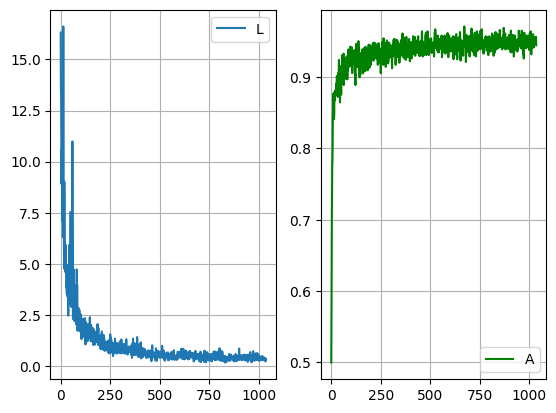

 65%|██████▍   | 255/393 [00:09<00:07, 19.41it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 250] Loss: 0.5708 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 251] Loss: 0.2826 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 252] Loss: 0.3466 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 253] Loss: 0.5166 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 254] Loss: 0.3353 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 255] Loss: 0.4357 | Acc: 0.9355
torch.Size([8, 128, 384, 384])


 67%|██████▋   | 262/393 [00:10<00:05, 23.72it/s]

[Epoch 2 Step 256] Loss: 0.3769 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 257] Loss: 0.3923 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 258] Loss: 0.3417 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 259] Loss: 0.2765 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 260] Loss: 0.3578 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 261] Loss: 0.3806 | Acc: 0.9512
torch.Size([8, 128, 384, 384])


 68%|██████▊   | 269/393 [00:10<00:04, 27.02it/s]

[Epoch 2 Step 262] Loss: 0.4300 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 263] Loss: 0.2390 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 264] Loss: 0.2551 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 265] Loss: 0.5170 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 266] Loss: 0.3785 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 267] Loss: 0.3230 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 268] Loss: 0.3931 | Acc: 0.9463


 69%|██████▉   | 272/393 [00:10<00:04, 27.71it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 269] Loss: 0.3330 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 270] Loss: 0.4195 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 271] Loss: 0.5911 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 272] Loss: 0.3245 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 273] Loss: 0.3099 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 274] Loss: 0.3632 | Acc: 0.9570


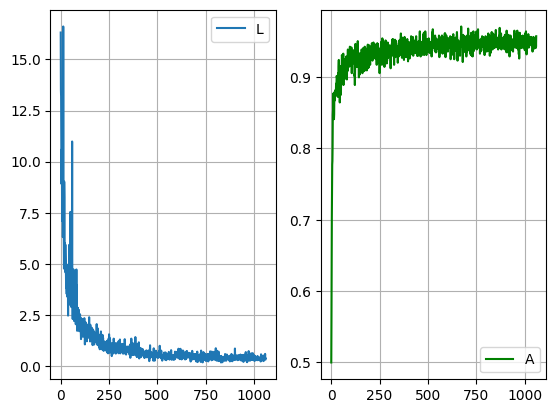

 72%|███████▏  | 282/393 [00:11<00:05, 21.04it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 275] Loss: 0.4037 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 276] Loss: 0.4316 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 277] Loss: 0.3226 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 278] Loss: 0.2886 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 279] Loss: 0.3049 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 280] Loss: 0.3134 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 281] Loss: 0.1826 | Acc: 0.9668


 73%|███████▎  | 286/393 [00:11<00:04, 24.35it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 282] Loss: 0.5354 | Acc: 0.9355
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 283] Loss: 0.5067 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 284] Loss: 0.6129 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 285] Loss: 0.3226 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 286] Loss: 0.2583 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 287] Loss: 0.5207 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 288] Loss: 0.3796 | Acc: 0.9531
torch.Size([8, 128, 384, 384])


 75%|███████▍  | 294/393 [00:11<00:03, 29.71it/s]

[Epoch 2 Step 289] Loss: 0.4454 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 290] Loss: 0.2765 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 291] Loss: 0.2726 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 292] Loss: 0.2562 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 293] Loss: 0.2641 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 294] Loss: 0.2273 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 295] Loss: 0.3165 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 296] Loss: 0.3607 | Acc: 0.9473
torch.Size([8, 128, 384, 384])


 76%|███████▌  | 298/393 [00:11<00:03, 31.62it/s]

[Epoch 2 Step 297] Loss: 0.2693 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 298] Loss: 0.3101 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 299] Loss: 0.4055 | Acc: 0.9482


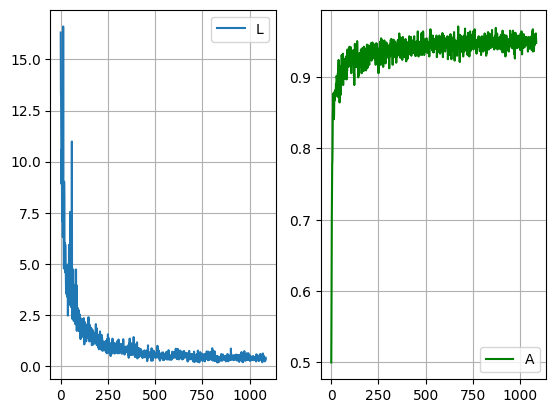

 78%|███████▊  | 306/393 [00:12<00:06, 13.51it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 300] Loss: 0.5109 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 301] Loss: 0.5533 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 302] Loss: 0.3405 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 303] Loss: 0.4250 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 304] Loss: 0.4721 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 305] Loss: 0.4353 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 306] Loss: 0.2753 | Acc: 0.9443


 80%|███████▉  | 314/393 [00:12<00:04, 19.53it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 307] Loss: 0.3867 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 308] Loss: 0.3951 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 309] Loss: 0.3090 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 310] Loss: 0.6449 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 311] Loss: 0.2377 | Acc: 0.9658
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 312] Loss: 0.5974 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 313] Loss: 0.3141 | Acc: 0.9521


 81%|████████  | 318/393 [00:12<00:03, 22.24it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 314] Loss: 0.4883 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 315] Loss: 0.2938 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 316] Loss: 0.3220 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 317] Loss: 0.3873 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 318] Loss: 0.4632 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 319] Loss: 0.4929 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 320] Loss: 0.2408 | Acc: 0.9668


 82%|████████▏ | 322/393 [00:12<00:02, 24.79it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 321] Loss: 0.4074 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 322] Loss: 0.4162 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 323] Loss: 0.2833 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 324] Loss: 0.2651 | Acc: 0.9502


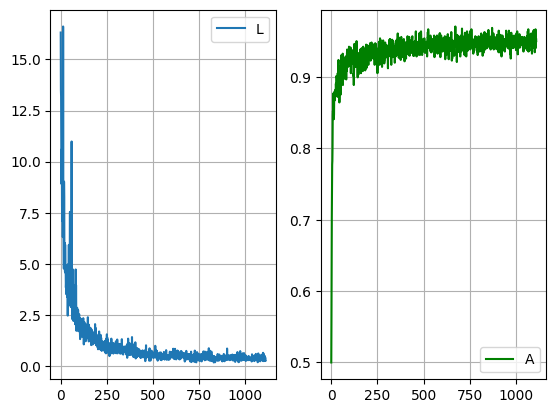

 84%|████████▍ | 330/393 [00:13<00:03, 20.19it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 325] Loss: 0.4112 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 326] Loss: 0.4376 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 327] Loss: 0.3650 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 328] Loss: 0.4866 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 329] Loss: 0.3050 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 330] Loss: 0.2469 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 331] Loss: 0.5426 | Acc: 0.9482


 86%|████████▌ | 338/393 [00:13<00:02, 25.39it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 332] Loss: 0.4201 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 333] Loss: 0.1230 | Acc: 0.9707
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 334] Loss: 0.4380 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 335] Loss: 0.4279 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 336] Loss: 0.5120 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 337] Loss: 0.2607 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 338] Loss: 0.4694 | Acc: 0.9404


 88%|████████▊ | 346/393 [00:13<00:01, 29.13it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 339] Loss: 0.3569 | Acc: 0.9297
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 340] Loss: 0.2371 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 341] Loss: 0.3866 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 342] Loss: 0.3743 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 343] Loss: 0.3610 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 344] Loss: 0.7420 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 345] Loss: 0.3187 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 346] Loss: 0.3332 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 347] Loss: 0.3605 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 348] Loss: 0.4059 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 349] Loss: 0.3433 | Acc: 0.9395


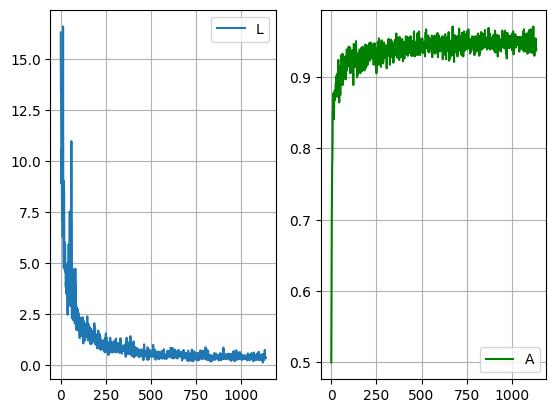

 90%|█████████ | 354/393 [00:14<00:01, 21.54it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 350] Loss: 0.4939 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 351] Loss: 0.3210 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 352] Loss: 0.2456 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 353] Loss: 0.3269 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 354] Loss: 0.2126 | Acc: 0.9697
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 355] Loss: 0.5875 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 356] Loss: 0.3646 | Acc: 0.9521
torch.Size([8, 128, 384, 384])


 92%|█████████▏| 362/393 [00:14<00:01, 26.71it/s]

[Epoch 2 Step 357] Loss: 0.4371 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 358] Loss: 0.4114 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 359] Loss: 0.4391 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 360] Loss: 0.2625 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 361] Loss: 0.4221 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 362] Loss: 0.4775 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 363] Loss: 0.3353 | Acc: 0.9600
torch.Size([8, 128, 384, 384])


 94%|█████████▍| 370/393 [00:14<00:00, 29.74it/s]

[Epoch 2 Step 364] Loss: 0.3345 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 365] Loss: 0.3257 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 366] Loss: 0.4145 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 367] Loss: 0.3798 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 368] Loss: 0.3542 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 369] Loss: 0.5049 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 370] Loss: 0.3560 | Acc: 0.9502
torch.Size([8, 128, 384, 384])


 95%|█████████▌| 374/393 [00:15<00:00, 30.91it/s]

[Epoch 2 Step 371] Loss: 0.5202 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 372] Loss: 0.3253 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 373] Loss: 0.2652 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 374] Loss: 0.4562 | Acc: 0.9434


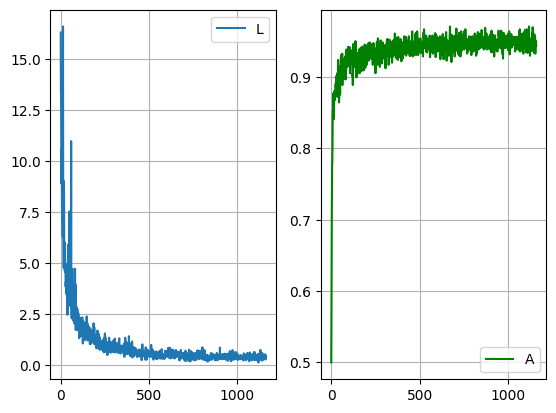

 97%|█████████▋| 382/393 [00:15<00:00, 22.32it/s]

torch.Size([8, 128, 384, 384])
[Epoch 2 Step 375] Loss: 0.3689 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 376] Loss: 0.4030 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 377] Loss: 0.4756 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 378] Loss: 0.3897 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 379] Loss: 0.2970 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 380] Loss: 0.3377 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 381] Loss: 0.2576 | Acc: 0.9580
torch.Size([8, 128, 384, 384])


 98%|█████████▊| 386/393 [00:15<00:00, 24.91it/s]

[Epoch 2 Step 382] Loss: 0.2723 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 383] Loss: 0.3654 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 384] Loss: 0.6590 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 385] Loss: 0.3259 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 386] Loss: 0.3228 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 387] Loss: 0.2219 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 388] Loss: 0.5422 | Acc: 0.9443
torch.Size([8, 128, 384, 384])


100%|██████████| 393/393 [00:15<00:00, 24.73it/s]


[Epoch 2 Step 389] Loss: 0.4122 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 390] Loss: 0.3778 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 2 Step 391] Loss: 0.3671 | Acc: 0.9482
torch.Size([3, 128, 384, 384])
[Epoch 2 Step 392] Loss: 0.3537 | Acc: 0.9531


  0%|          | 0/393 [00:00<?, ?it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 0] Loss: 0.3278 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 1] Loss: 0.3120 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 2] Loss: 0.4077 | Acc: 0.9551
torch.Size([8, 128, 384, 384])


  1%|          | 4/393 [00:00<00:11, 32.91it/s]

[Epoch 3 Step 3] Loss: 0.4621 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 4] Loss: 0.2277 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 5] Loss: 0.3239 | Acc: 0.9570
torch.Size([8, 128, 384, 384])


  2%|▏         | 8/393 [00:00<00:11, 32.52it/s]

[Epoch 3 Step 6] Loss: 0.3075 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 7] Loss: 0.3548 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 8] Loss: 0.3777 | Acc: 0.9629
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 9] Loss: 0.3577 | Acc: 0.9502
torch.Size([8, 128, 384, 384])


  3%|▎         | 12/393 [00:00<00:11, 32.89it/s]

[Epoch 3 Step 10] Loss: 0.5442 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 11] Loss: 0.2777 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 12] Loss: 0.3455 | Acc: 0.9570
torch.Size([8, 128, 384, 384])


  4%|▍         | 16/393 [00:00<00:11, 33.40it/s]

[Epoch 3 Step 13] Loss: 0.2885 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 14] Loss: 0.2679 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 15] Loss: 0.3888 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 16] Loss: 0.2800 | Acc: 0.9609
torch.Size([8, 128, 384, 384])


  5%|▌         | 20/393 [00:00<00:11, 33.49it/s]

[Epoch 3 Step 17] Loss: 0.4027 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 18] Loss: 0.4738 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 19] Loss: 0.4372 | Acc: 0.9482
torch.Size([8, 128, 384, 384])


  6%|▌         | 24/393 [00:00<00:10, 33.69it/s]

[Epoch 3 Step 20] Loss: 0.4374 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 21] Loss: 0.3756 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 22] Loss: 0.3317 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 23] Loss: 0.2550 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 24] Loss: 0.4201 | Acc: 0.9541


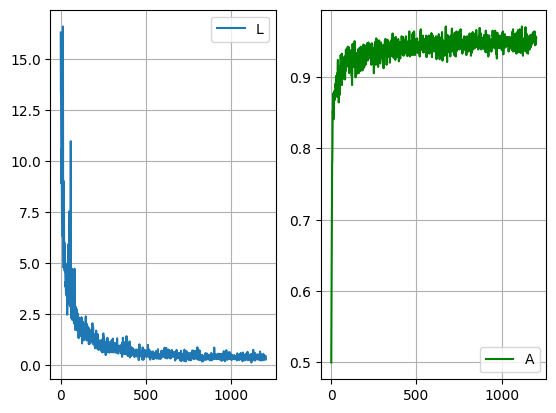

  8%|▊         | 32/393 [00:01<00:16, 22.50it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 25] Loss: 0.3708 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 26] Loss: 0.5276 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 27] Loss: 0.7804 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 28] Loss: 0.3033 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 29] Loss: 0.3379 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 30] Loss: 0.2850 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 31] Loss: 0.3139 | Acc: 0.9473


  9%|▉         | 36/393 [00:01<00:14, 25.15it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 32] Loss: 0.5094 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 33] Loss: 0.2853 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 34] Loss: 0.5040 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 35] Loss: 0.5162 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 36] Loss: 0.4987 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 37] Loss: 0.4538 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 38] Loss: 0.3133 | Acc: 0.9502
torch.Size([8, 128, 384, 384])


 11%|█         | 44/393 [00:01<00:11, 29.40it/s]

[Epoch 3 Step 39] Loss: 0.2842 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 40] Loss: 0.2857 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 41] Loss: 0.3401 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 42] Loss: 0.2962 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 43] Loss: 0.3857 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 44] Loss: 0.6025 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 45] Loss: 0.2886 | Acc: 0.9551
torch.Size([8, 128, 384, 384])


 12%|█▏        | 48/393 [00:01<00:11, 30.54it/s]

[Epoch 3 Step 46] Loss: 0.2644 | Acc: 0.9629
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 47] Loss: 0.4051 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 48] Loss: 0.3062 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 49] Loss: 0.3160 | Acc: 0.9600


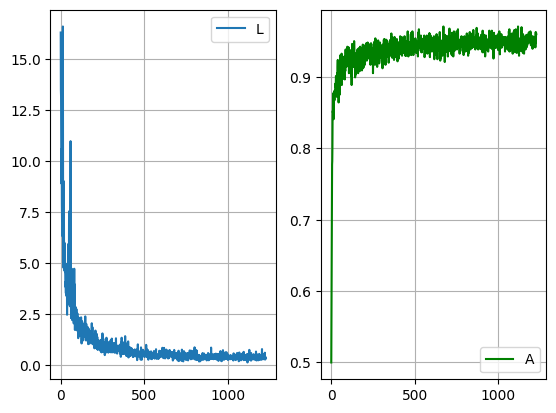

 14%|█▍        | 56/393 [00:02<00:14, 22.62it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 50] Loss: 0.3825 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 51] Loss: 0.2417 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 52] Loss: 0.2605 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 53] Loss: 0.2158 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 54] Loss: 0.5128 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 55] Loss: 0.4298 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 56] Loss: 0.3740 | Acc: 0.9414
torch.Size([8, 128, 384, 384])


 16%|█▋        | 64/393 [00:02<00:11, 27.56it/s]

[Epoch 3 Step 57] Loss: 0.2407 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 58] Loss: 0.4227 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 59] Loss: 0.2444 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 60] Loss: 0.4576 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 61] Loss: 0.3428 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 62] Loss: 0.3431 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 63] Loss: 0.3838 | Acc: 0.9502
torch.Size([8, 128, 384, 384])


 17%|█▋        | 68/393 [00:02<00:11, 29.26it/s]

[Epoch 3 Step 64] Loss: 0.3923 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 65] Loss: 0.3886 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 66] Loss: 0.3429 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 67] Loss: 0.3124 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 68] Loss: 0.2914 | Acc: 0.9648
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 69] Loss: 0.5950 | Acc: 0.9277
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 70] Loss: 0.5696 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 71] Loss: 0.3058 | Acc: 0.9463


 18%|█▊        | 72/393 [00:02<00:10, 30.82it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 72] Loss: 0.4362 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 73] Loss: 0.2196 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 74] Loss: 0.3841 | Acc: 0.9404


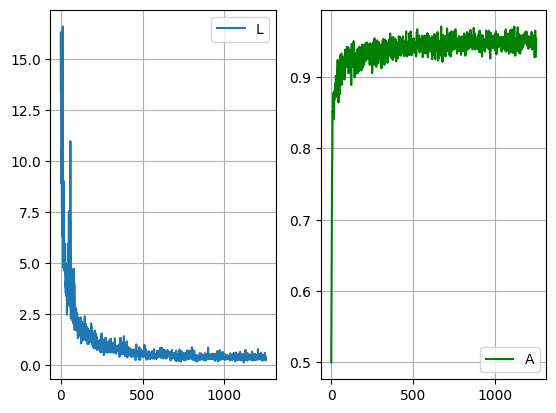

 20%|██        | 80/393 [00:03<00:13, 22.58it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 75] Loss: 0.3810 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 76] Loss: 0.5168 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 77] Loss: 0.4019 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 78] Loss: 0.3828 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 79] Loss: 0.3689 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 80] Loss: 0.4394 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 81] Loss: 0.3222 | Acc: 0.9375


 22%|██▏       | 88/393 [00:03<00:11, 27.38it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 82] Loss: 0.4034 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 83] Loss: 0.5597 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 84] Loss: 0.2641 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 85] Loss: 0.2515 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 86] Loss: 0.2828 | Acc: 0.9648
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 87] Loss: 0.6216 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 88] Loss: 0.4597 | Acc: 0.9482


 24%|██▍       | 96/393 [00:03<00:09, 30.64it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 89] Loss: 0.3194 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 90] Loss: 0.2743 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 91] Loss: 0.4790 | Acc: 0.9346
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 92] Loss: 0.4725 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 93] Loss: 0.3059 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 94] Loss: 0.2746 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 95] Loss: 0.1955 | Acc: 0.9648
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 96] Loss: 0.4535 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 97] Loss: 0.2765 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 98] Loss: 0.3659 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 99] Loss: 0.5735 | Acc: 0.9424


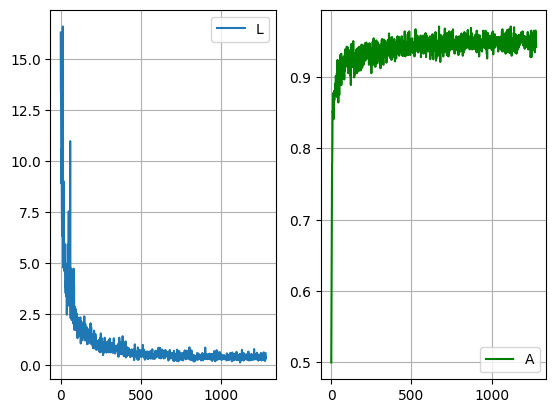

 26%|██▋       | 104/393 [00:04<00:13, 22.11it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 100] Loss: 0.3650 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 101] Loss: 0.3101 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 102] Loss: 0.5288 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 103] Loss: 0.2973 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 104] Loss: 0.5444 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 105] Loss: 0.3495 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 106] Loss: 0.2740 | Acc: 0.9648


 28%|██▊       | 112/393 [00:04<00:10, 27.15it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 107] Loss: 0.2539 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 108] Loss: 0.2778 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 109] Loss: 0.3607 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 110] Loss: 0.2885 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 111] Loss: 0.5281 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 112] Loss: 0.6085 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 113] Loss: 0.4566 | Acc: 0.9512
torch.Size([8, 128, 384, 384])


 31%|███       | 120/393 [00:04<00:09, 30.14it/s]

[Epoch 3 Step 114] Loss: 0.5595 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 115] Loss: 0.3593 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 116] Loss: 0.4239 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 117] Loss: 0.2699 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 118] Loss: 0.2957 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 119] Loss: 0.4499 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 120] Loss: 0.4901 | Acc: 0.9482
torch.Size([8, 128, 384, 384])


 32%|███▏      | 124/393 [00:04<00:08, 31.17it/s]

[Epoch 3 Step 121] Loss: 0.3067 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 122] Loss: 0.3256 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 123] Loss: 0.4273 | Acc: 0.9307
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 124] Loss: 0.5136 | Acc: 0.9453


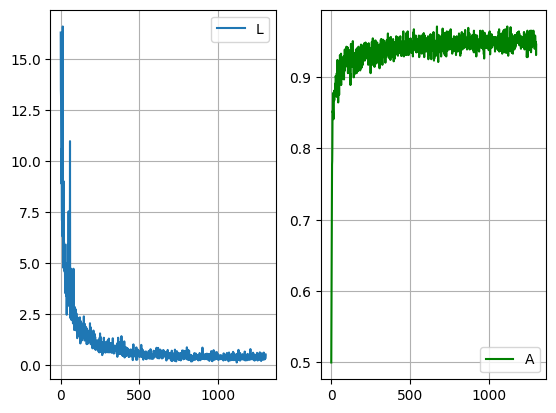

 33%|███▎      | 131/393 [00:05<00:12, 21.01it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 125] Loss: 0.4303 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 126] Loss: 0.3219 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 127] Loss: 0.3221 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 128] Loss: 0.6095 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 129] Loss: 0.5520 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 130] Loss: 0.3614 | Acc: 0.9600


 35%|███▍      | 137/393 [00:05<00:10, 24.27it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 131] Loss: 0.3067 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 132] Loss: 0.3695 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 133] Loss: 0.3566 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 134] Loss: 0.4435 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 135] Loss: 0.3430 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 136] Loss: 0.3717 | Acc: 0.9414
torch.Size([8, 128, 384, 384])


 36%|███▌      | 141/393 [00:05<00:09, 26.37it/s]

[Epoch 3 Step 137] Loss: 0.3589 | Acc: 0.9365
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 138] Loss: 0.5617 | Acc: 0.9316
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 139] Loss: 0.2927 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 140] Loss: 0.2749 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 141] Loss: 0.3309 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 142] Loss: 0.3275 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 143] Loss: 0.2980 | Acc: 0.9473


 37%|███▋      | 147/393 [00:05<00:08, 27.48it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 144] Loss: 0.5732 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 145] Loss: 0.3895 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 146] Loss: 0.3584 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 147] Loss: 0.4082 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 148] Loss: 0.2963 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 149] Loss: 0.3186 | Acc: 0.9463


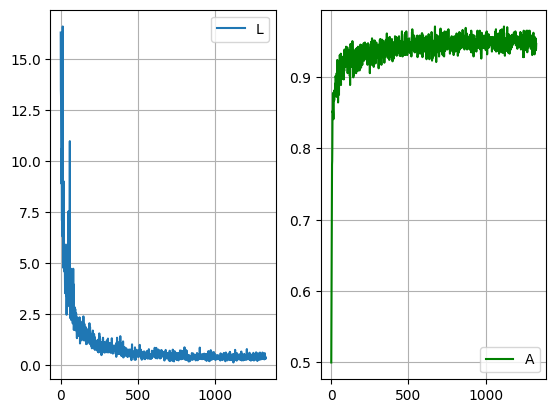

 39%|███▉      | 153/393 [00:06<00:13, 17.43it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 150] Loss: 0.4743 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 151] Loss: 0.4377 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 152] Loss: 0.3430 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 153] Loss: 0.4056 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 154] Loss: 0.4513 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 155] Loss: 0.3890 | Acc: 0.9668
torch.Size([8, 128, 384, 384])


 41%|████      | 161/393 [00:06<00:09, 23.49it/s]

[Epoch 3 Step 156] Loss: 0.3625 | Acc: 0.9639
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 157] Loss: 0.4555 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 158] Loss: 0.4392 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 159] Loss: 0.3422 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 160] Loss: 0.3502 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 161] Loss: 0.2858 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 162] Loss: 0.2812 | Acc: 0.9521


 43%|████▎     | 168/393 [00:06<00:08, 26.33it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 163] Loss: 0.3280 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 164] Loss: 0.5228 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 165] Loss: 0.3601 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 166] Loss: 0.3215 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 167] Loss: 0.2763 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 168] Loss: 0.4679 | Acc: 0.9473


 44%|████▍     | 172/393 [00:06<00:07, 27.65it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 169] Loss: 0.3644 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 170] Loss: 0.4305 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 171] Loss: 0.3137 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 172] Loss: 0.3425 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 173] Loss: 0.4142 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 174] Loss: 0.3552 | Acc: 0.9473


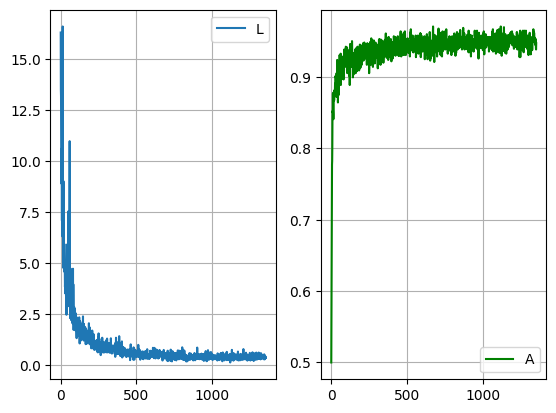

 46%|████▋     | 182/393 [00:07<00:10, 21.02it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 175] Loss: 0.3760 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 176] Loss: 0.2130 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 177] Loss: 0.3022 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 178] Loss: 0.3249 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 179] Loss: 0.3285 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 180] Loss: 0.3076 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 181] Loss: 0.3008 | Acc: 0.9609


 47%|████▋     | 186/393 [00:07<00:08, 24.05it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 182] Loss: 0.6885 | Acc: 0.9336
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 183] Loss: 0.2891 | Acc: 0.9619
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 184] Loss: 0.4231 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 185] Loss: 0.3574 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 186] Loss: 0.3056 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 187] Loss: 0.3820 | Acc: 0.9648
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 188] Loss: 0.3902 | Acc: 0.9512
torch.Size([8, 128, 384, 384])


 49%|████▉     | 194/393 [00:07<00:06, 28.70it/s]

[Epoch 3 Step 189] Loss: 0.6401 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 190] Loss: 0.3281 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 191] Loss: 0.2723 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 192] Loss: 0.4947 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 193] Loss: 0.4247 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 194] Loss: 0.4952 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 195] Loss: 0.4043 | Acc: 0.9482
torch.Size([8, 128, 384, 384])


 50%|█████     | 198/393 [00:07<00:06, 30.07it/s]

[Epoch 3 Step 196] Loss: 0.2055 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 197] Loss: 0.4266 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 198] Loss: 0.2624 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 199] Loss: 0.2972 | Acc: 0.9443


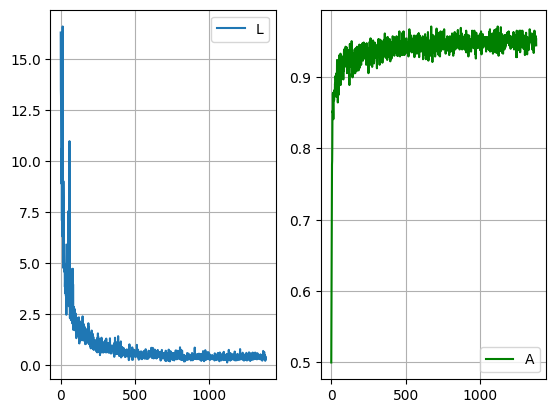

 52%|█████▏    | 206/393 [00:08<00:08, 22.12it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 200] Loss: 0.4384 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 201] Loss: 0.3001 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 202] Loss: 0.2642 | Acc: 0.9600
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 203] Loss: 0.3761 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 204] Loss: 0.2749 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 205] Loss: 0.3840 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 206] Loss: 0.3208 | Acc: 0.9502
torch.Size([8, 128, 384, 384])


 54%|█████▍    | 214/393 [00:08<00:06, 26.91it/s]

[Epoch 3 Step 207] Loss: 0.4179 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 208] Loss: 0.3306 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 209] Loss: 0.3763 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 210] Loss: 0.3782 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 211] Loss: 0.3756 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 212] Loss: 0.3757 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 213] Loss: 0.5985 | Acc: 0.9404
torch.Size([8, 128, 384, 384])


 55%|█████▌    | 218/393 [00:08<00:06, 28.66it/s]

[Epoch 3 Step 214] Loss: 0.4162 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 215] Loss: 0.2649 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 216] Loss: 0.3903 | Acc: 0.9287
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 217] Loss: 0.4203 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 218] Loss: 0.3031 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 219] Loss: 0.3536 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 220] Loss: 0.2875 | Acc: 0.9570
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 221] Loss: 0.3234 | Acc: 0.9492


 56%|█████▋    | 222/393 [00:08<00:05, 30.43it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 222] Loss: 0.2903 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 223] Loss: 0.3017 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 224] Loss: 0.5687 | Acc: 0.9600


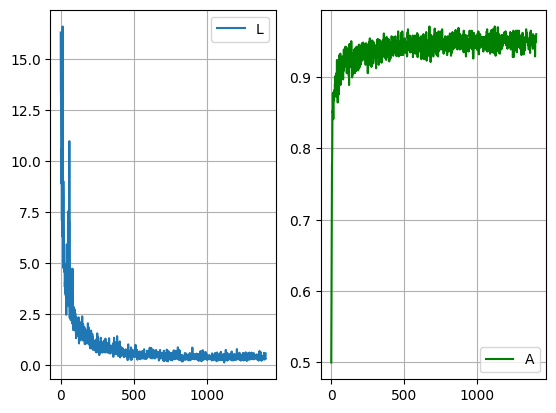

 59%|█████▊    | 230/393 [00:09<00:07, 22.49it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 225] Loss: 0.2686 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 226] Loss: 0.2904 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 227] Loss: 0.4373 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 228] Loss: 0.4480 | Acc: 0.9443
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 229] Loss: 0.4242 | Acc: 0.9404
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 230] Loss: 0.3682 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 231] Loss: 0.3535 | Acc: 0.9453


 61%|██████    | 238/393 [00:09<00:05, 26.73it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 232] Loss: 0.3040 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 233] Loss: 0.3216 | Acc: 0.9414
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 234] Loss: 0.2917 | Acc: 0.9541
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 235] Loss: 0.3013 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 236] Loss: 0.3291 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 237] Loss: 0.3279 | Acc: 0.9648
torch.Size([8, 128, 384, 384])


 62%|██████▏   | 242/393 [00:09<00:05, 28.43it/s]

[Epoch 3 Step 238] Loss: 0.2585 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 239] Loss: 0.5168 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 240] Loss: 0.4393 | Acc: 0.9326
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 241] Loss: 0.3264 | Acc: 0.9424
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 242] Loss: 0.3371 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 243] Loss: 0.5058 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 244] Loss: 0.2171 | Acc: 0.9580
torch.Size([8, 128, 384, 384])


 63%|██████▎   | 246/393 [00:09<00:04, 29.79it/s]

[Epoch 3 Step 245] Loss: 0.2575 | Acc: 0.9551
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 246] Loss: 0.3145 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 247] Loss: 0.2886 | Acc: 0.9580
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 248] Loss: 0.3149 | Acc: 0.9531
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 249] Loss: 0.3786 | Acc: 0.9482


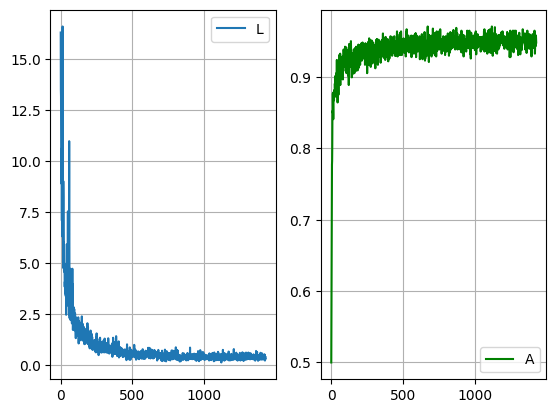

 65%|██████▍   | 254/393 [00:10<00:06, 22.08it/s]

torch.Size([8, 128, 384, 384])
[Epoch 3 Step 250] Loss: 0.2919 | Acc: 0.9434
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 251] Loss: 0.2816 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 252] Loss: 0.3697 | Acc: 0.9492
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 253] Loss: 0.3576 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 254] Loss: 0.3521 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 255] Loss: 0.2892 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 256] Loss: 0.2899 | Acc: 0.9453
torch.Size([8, 128, 384, 384])


 67%|██████▋   | 262/393 [00:10<00:04, 27.06it/s]

[Epoch 3 Step 257] Loss: 0.4121 | Acc: 0.9590
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 258] Loss: 0.5345 | Acc: 0.9395
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 259] Loss: 0.3454 | Acc: 0.9512
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 260] Loss: 0.4316 | Acc: 0.9453
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 261] Loss: 0.4403 | Acc: 0.9375
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 262] Loss: 0.4877 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 263] Loss: 0.4389 | Acc: 0.9482
torch.Size([8, 128, 384, 384])


 69%|██████▊   | 270/393 [00:10<00:04, 30.59it/s]

[Epoch 3 Step 264] Loss: 0.4019 | Acc: 0.9482
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 265] Loss: 0.3391 | Acc: 0.9473
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 266] Loss: 0.2510 | Acc: 0.9609
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 267] Loss: 0.3762 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 268] Loss: 0.3154 | Acc: 0.9561
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 269] Loss: 0.5322 | Acc: 0.9385
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 270] Loss: 0.4894 | Acc: 0.9482
torch.Size([8, 128, 384, 384])


 70%|██████▉   | 274/393 [00:11<00:03, 31.46it/s]

[Epoch 3 Step 271] Loss: 0.5319 | Acc: 0.9463
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 272] Loss: 0.3601 | Acc: 0.9502
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 273] Loss: 0.3462 | Acc: 0.9521
torch.Size([8, 128, 384, 384])
[Epoch 3 Step 274] Loss: 0.3311 | Acc: 0.9492


 70%|██████▉   | 274/393 [00:11<00:04, 24.53it/s]


KeyboardInterrupt: 

In [55]:
teacher.eval()

la = LinearAttention(teacher.d_model).to(device)

optimizer = torch.optim.Adam(la.parameters(), lr=1e-3)

# === Training loop ===
bla_loss_results = []
bla_acc_results = []

loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(3):
    for step, batch in enumerate(tqdm(dataloader)):
        context_ids = batch["input_ids"].cuda()
        labels = batch["labels"].cuda()

        with torch.no_grad():
            _, attn_weights = teacher(context_ids)  # (B, L, L)
            top1_indices = attn_weights.argmax(dim=-1)  # (B, L)
            B, L = top1_indices.shape

        summaries = la.build_summaries(context_ids)
        predictions = la.forward(
            context_ids,
            summaries
        )

        loss = loss_fn(predictions.reshape(B * L, 2), (top1_indices // (top1_indices.shape[1] // 2)).reshape(B * L))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        acc = ((predictions.argmax(-1) == (top1_indices // (top1_indices.shape[1] // 2))).sum() / (B * L)).item()

        print(f"[Epoch {epoch} Step {step}] Loss: {loss.item():.4f} | Acc: {acc:.4f}")

        bla_acc_results.append(acc)
        bla_loss_results.append(loss.item())

        if (step+1) % 25 == 0:
          fig, ax = plt.subplots(1, 2)

          ax[0].plot(bla_loss_results)
          ax[0].legend("Loss Curve")
          ax[1].plot(bla_acc_results, color="green")
          ax[1].legend("Accuracy Curve")
          for a in ax:
            a.grid()
          plt.show()
          time.sleep(0.1)

        open("bla_metrics.json", "w").write(json.dumps({
            "loss_curve" : bla_loss_results,
            "acc_curve" : bla_acc_results
        }))
